# Trump Speech Analysis for 2025 SOTU Predictions

This notebook analyzes the frequency of specific phrases to predict their occurrence in the 2025 SOTU address using:
1. Regular speeches (pre-inauguration)
2. Post-inauguration speeches (Jan 20, 2025 onwards)
3. Previous State of the Union addresses

## Setup

In [7]:
import os
import re
from datetime import datetime
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
plt.style.use('default')
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]

# Set pandas display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [8]:
INAUGURATION_DATE = datetime(2025, 1, 20)
CONTEXT_WINDOW = 200 # words to display for context

Phrases to Track

Crime
Border
Justice
Law and order
Weapon / Weaponization
Kash / Patel
Police
Hunter / Biden
Judge
Death penalty
National Security
Sanctuary
Pardon
Golden Age
Lawfare
Bill / Barr
Clean house
Antifa / Anti-fa / Anti-fascist
Insurrection
Civil rights
FISA court
Prison reform
Martial law
Jeff / Sessions

In [9]:
SEARCH_PHRASES = {
    "Dead Country": r'\bdead\s+countrys?(?:\'s?)?(?:-\w+)?\b',
    "Too Big to Rig": r'\btoo\s+big\s+to\s+rigs?(?:\'s?)?(?:-\w+)?\b',
    "Ballroom": r'\bballrooms?(?:\'s?)?(?:-\w+)?\b',
    "Zelenskyy": r'\bzelenskyys?(?:\'s?)?(?:-\w+)?\b',
    "Newscum": r'\bnewscums?(?:\'s?)?(?:-\w+)?\b',
    "Pelosi": r'\bpelosis?(?:\'s?)?(?:-\w+)?\b',
    "Bitcoin": r'\bbitcoins?(?:\'s?)?(?:-\w+)?\b',
    "Witch Hunt": r'\bwitch\s+hunts?(?:\'s?)?(?:-\w+)?\b',
    "Zohran": r'\b(?:zohrans?|mamdanis?)(?:\'s?)?(?:-\w+)?\b',
    "Epstein": r'\bepsteins?(?:\'s?)?(?:-\w+)?\b',
    "Sleepy Joe": r'\bsleepy\s+joes?(?:\'s?)?(?:-\w+)?\b',
    "Clean Beautiful Coal": r'\bclean\s+beautiful\s+coals?(?:\'s?)?(?:-\w+)?\b',
    "Palestine": r'\bpalestines?(?:\'s?)?(?:-\w+)?\b',
    "Schiff": r'\bschiffs?(?:\'s?)?(?:-\w+)?\b',
    "AOC": r'\baocs?(?:\'s?)?(?:-\w+)?\b',
    "Elon": r'\belons?(?:\'s?)?(?:-\w+)?\b',
    "Crooked Hillary": r'\bcrooked\s+hillarys?(?:\'s?)?(?:-\w+)?\b',
    "Con Job": r'\bcon\s+jobs?(?:\'s?)?(?:-\w+)?\b',
    "Hunter": r'\bhunters?(?:\'s?)?(?:-\w+)?\b',
    "Barack Hussein Obama": r'\bbarack\s+hussein\s+obamas?(?:\'s?)?(?:-\w+)?\b',
    "Ghislaine": r'\b(?:ghislaines?|maxwells?)(?:\'s?)?(?:-\w+)?\b',
    "Comey": r'\bcomeys?(?:\'s?)?(?:-\w+)?\b',
    "Recession": r'\brecessions?(?:\'s?)?(?:-\w+)?\b',
    "Loomer": r'\bloomers?(?:\'s?)?(?:-\w+)?\b',
    "Bill Clinton": r'\bbill\s+clintons?(?:\'s?)?(?:-\w+)?\b',
    "UFC": r'\bufcs?(?:\'s?)?(?:-\w+)?\b',
    "Massie": r'\bmassies?(?:\'s?)?(?:-\w+)?\b',
    "Larry Summers": r'\blarry\s+summers?(?:\'s?)?(?:-\w+)?\b',
    "South Park": r'\bsouth\s+parks?(?:\'s?)?(?:-\w+)?\b',
    "Swamp": r'\bswamps?(?:\'s?)?(?:-\w+)?\b',
    "Colbert": r'\bcolberts?(?:\'s?)?(?:-\w+)?\b',
    "Lyin Kamala": r'\blyin\s+kamalas?(?:\'s?)?(?:-\w+)?\b',
    "Paramount": r'\bparamounts?(?:\'s?)?(?:-\w+)?\b',
    "Two-State": r'\btwo-states?(?:\'s?)?(?:-\w+)?\b',
    "Lisa Monaco": r'\blisa\s+monacos?(?:\'s?)?(?:-\w+)?\b',
    "Nest Egg": r'\bnest\s+eggs?(?:\'s?)?(?:-\w+)?\b',
}

In [10]:
def count_phrases(text, phrases=SEARCH_PHRASES):
    """Count occurrences of phrases in text"""
    counts = {}
    for name, pattern in phrases.items():
        counts[name] = len(re.findall(pattern, text.lower()))
    return counts

def get_date_from_filename(filename):
    """Extract date from filename format YYYY-MM-DD_..."""
    date_str = filename.split('_')[0]
    return datetime.strptime(date_str, '%Y-%m-%d')

def read_transcript(filepath):
    """Read and return transcript text"""
    with open(filepath, 'r', encoding='utf-8') as f:
        return f.read()

def find_phrase_context(text, pattern, window=CONTEXT_WINDOW):
    """Find phrase in text with surrounding context"""
    matches = []
    for match in re.finditer(pattern, text.lower()):
        start = max(0, match.start() - window)
        end = min(len(text), match.end() + window)
        context = text[start:end]
        # Add ellipsis if we're not at the start/end of the text
        if start > 0:
            context = '...' + context
        if end < len(text):
            context = context + '...'
        matches.append(context)
    return matches

def process_directory(directory):
    """Process transcripts from speech and sotu directories only"""
    results = []
    categories_found = set()
    
    for root, _, files in os.walk(directory):
        category = os.path.basename(root)
        categories_found.add(category)
        for file in files:
            if file.endswith('.txt'):
                filepath = os.path.join(root, file)
                try:
                    date = get_date_from_filename(file)
                    text = read_transcript(filepath)
                    counts = count_phrases(text)
                    
                    results.append({
                        'date': date,
                        'file': file,
                        'category': category,
                        'text_length': len(text.split()),
                        'text': text,  # Store full text for context analysis
                        **counts
                    })
                except Exception as e:
                    print(f"Error processing {filepath}: {str(e)}")
    
    print("Categories found in directory:")
    for cat in sorted(categories_found):
        print(f"- {cat}")
    print("\nOnly 'speech' and 'sotu' categories will be analyzed.\n")
    
    return pd.DataFrame(results)


In [11]:

df = process_directory('.../data/processed-transcripts')
df

Categories found in directory:

Only 'speech' and 'sotu' categories will be analyzed.



Empty DataFrame
Columns: []
Index: []

In [16]:
# Set the category of interest
CATEGORY_OF_INTEREST = "interview"

# Process transcripts
df = process_directory('../data/processed-transcripts')
df = df.sort_values('date')

# Filter out press briefings and state of the union
df = df[df['category'] != 'press briefing']
df = df[df['category'] != 'sotu']

# Split data by date and category
speech_mask = df['category'] == 'speech'
category_mask = df['category'] == CATEGORY_OF_INTEREST
date_mask = df['date'] >= INAUGURATION_DATE

# Create category of interest dataframes 
df_category = df[category_mask]
df_category_pre = df[category_mask & ~date_mask]
df_category_post = df[category_mask & date_mask]

df_non_category = df[~category_mask]

# Create SOTU dataframes
sotu_mask = df['category'] == 'sotu'
df_sotu = df[sotu_mask]

df_pre = df[~date_mask]
df_post = df[date_mask]

# Print dataset statistics
print("Dataset Statistics:")

print(f"\n{CATEGORY_OF_INTEREST.title()}s:")
print(f"Pre-inauguration: {len(df_category_pre)}")
print(f"Post-inauguration: {len(df_category_post)}")
print("\nState of the Union:")
print(f"Total: {len(df_sotu)}")

print("\nWord Count Statistics:")

print(f"\n{CATEGORY_OF_INTEREST.title()}s:")
print(f"Pre-inauguration average length: {df_category_pre['text_length'].mean():.0f} words") 
print(f"Post-inauguration average length: {df_category_post['text_length'].mean():.0f} words")
print("\nState of the Union:")
print(f"Average length: {df_sotu['text_length'].mean():.0f} words")

print("\nDate Ranges:")

print(f"\n{CATEGORY_OF_INTEREST.title()}s:")
print(f"Pre-inauguration: {df_category_pre['date'].min().strftime('%Y-%m-%d')} to {df_category_pre['date'].max().strftime('%Y-%m-%d')}")
print(f"Post-inauguration: {df_category_post['date'].min().strftime('%Y-%m-%d')} to {df_category_post['date'].max().strftime('%Y-%m-%d')}")


Categories found in directory:
- donald trump vlog
- interview
- interview - pending
- press briefing
- press conference
- press gaggle
- processed-transcripts
- remarks
- sotu
- speech
- uncategorized

Only 'speech' and 'sotu' categories will be analyzed.

Dataset Statistics:

Interviews:
Pre-inauguration: 23
Post-inauguration: 25

State of the Union:
Total: 0

Word Count Statistics:

Interviews:
Pre-inauguration average length: 4385 words
Post-inauguration average length: 4350 words

State of the Union:
Average length: nan words

Date Ranges:

Interviews:
Pre-inauguration: 2024-05-04 to 2025-01-16
Post-inauguration: 2025-01-22 to 2025-08-01


## Phrase Frequency Over Time

Speeches dropped off dramatically between election day and inauguration day. Non-speech transcripts mostly don't go back as far in time (need to scrape more data)

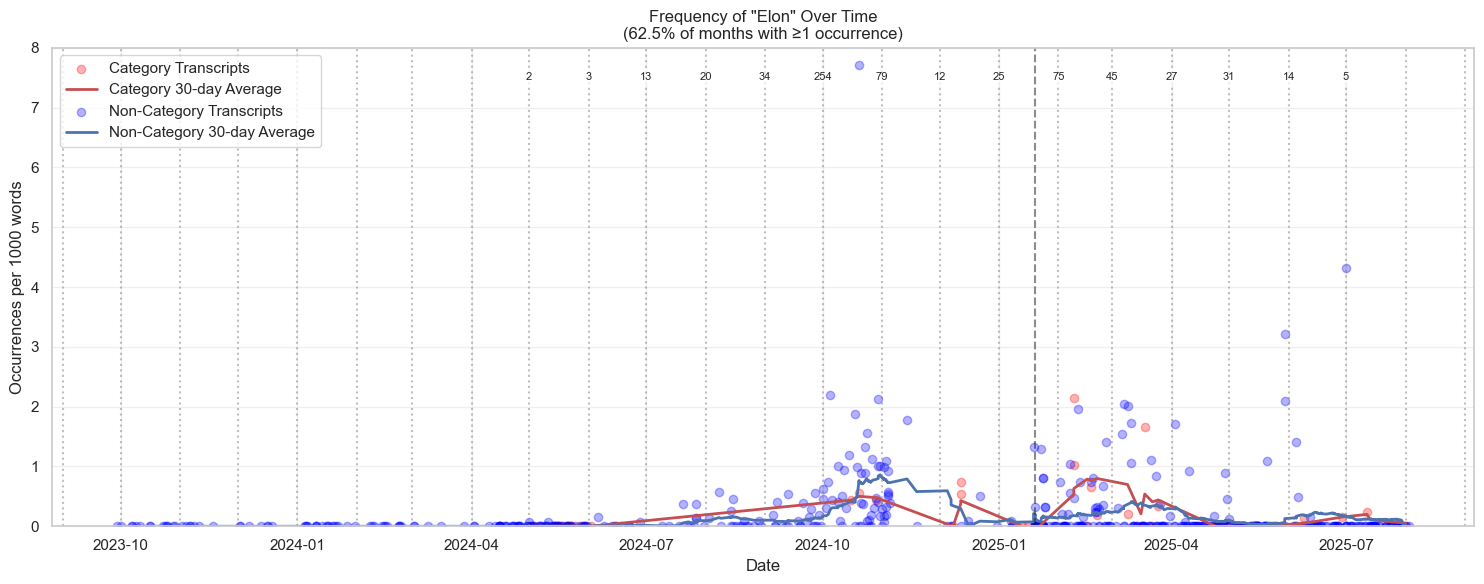

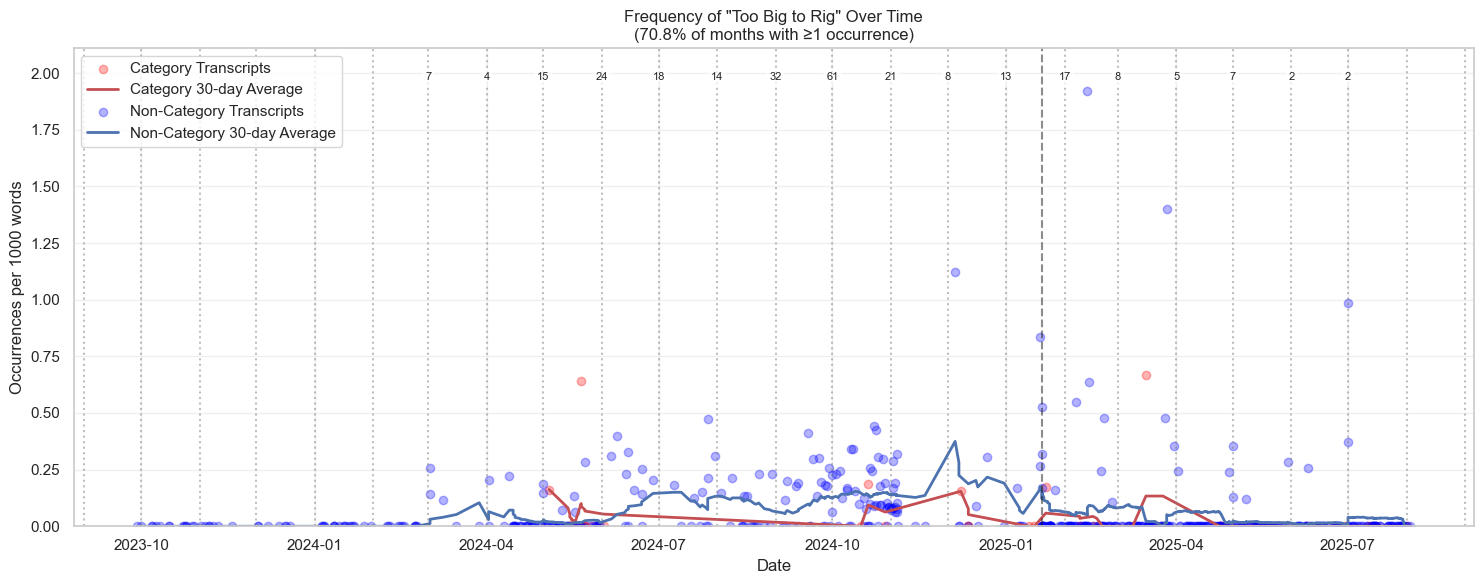

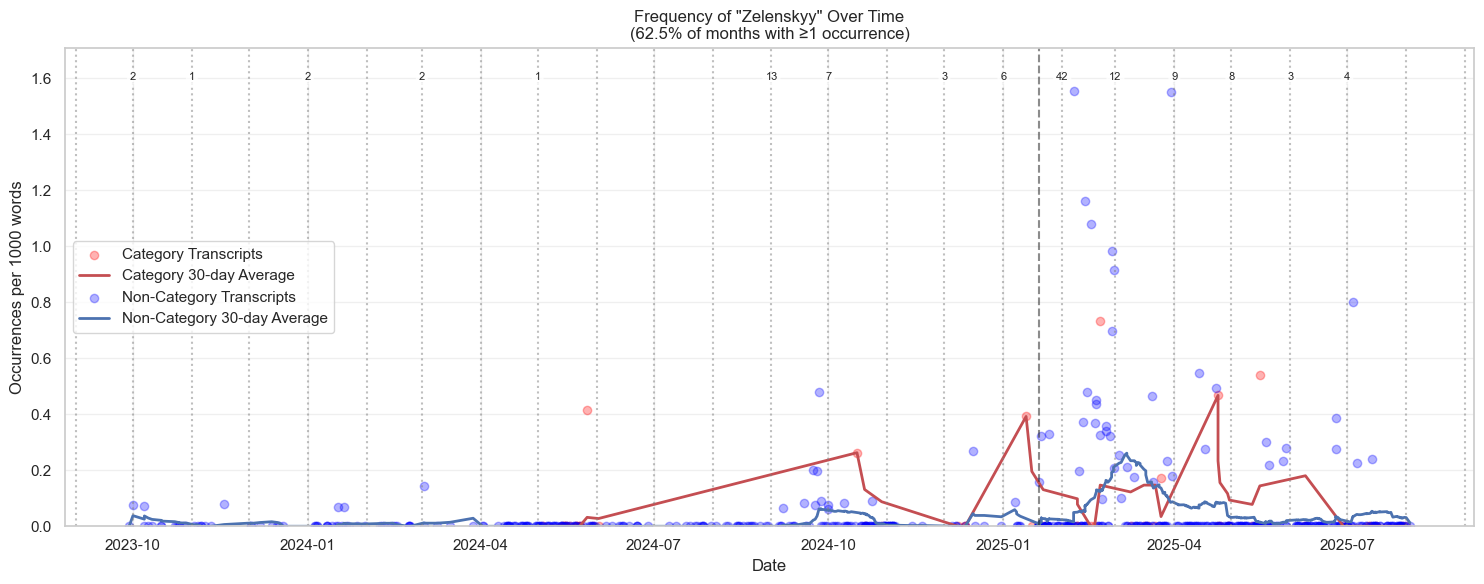

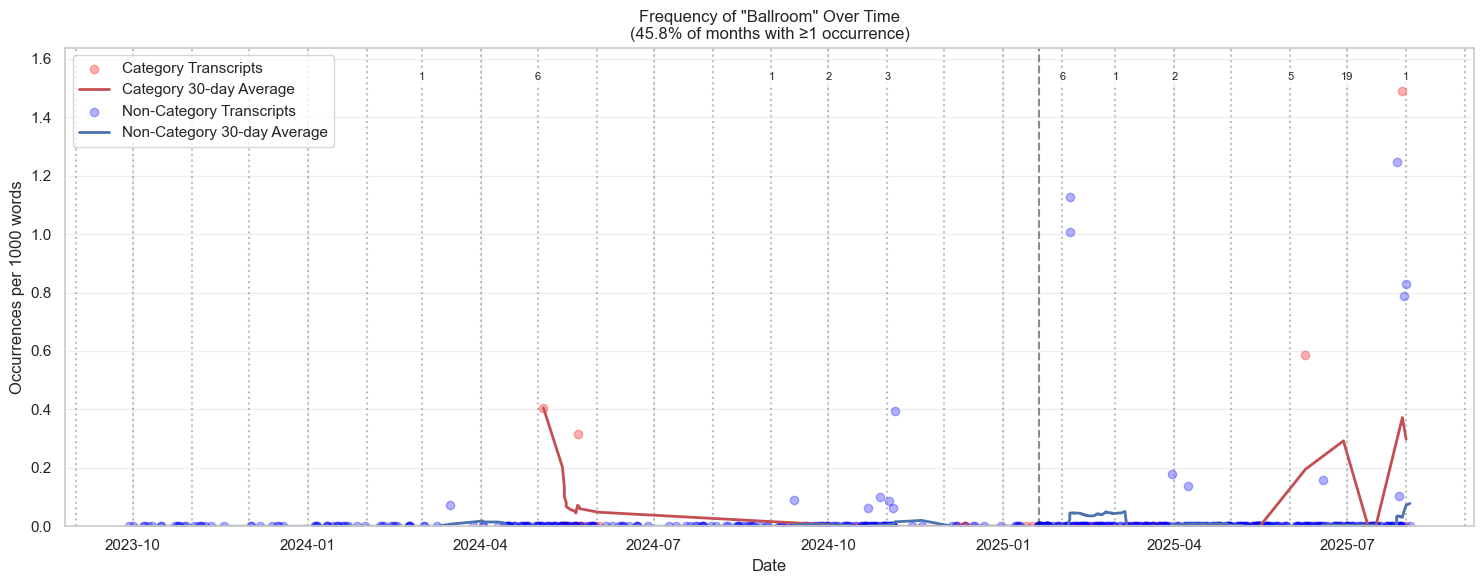

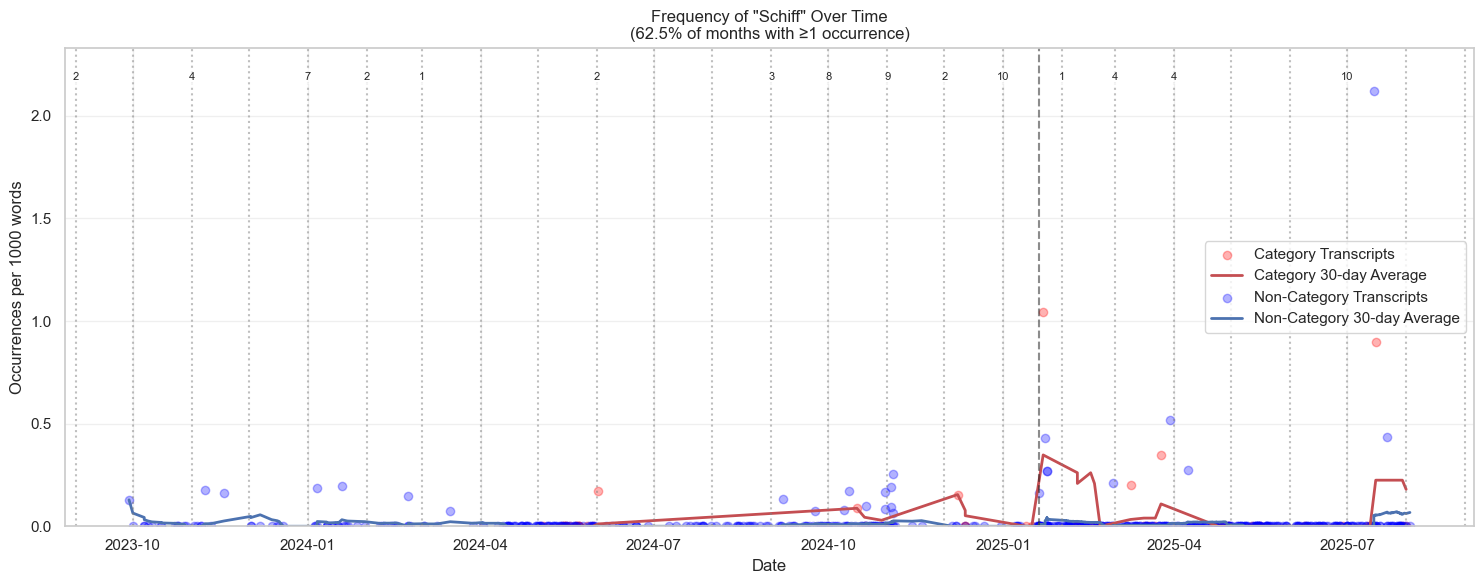

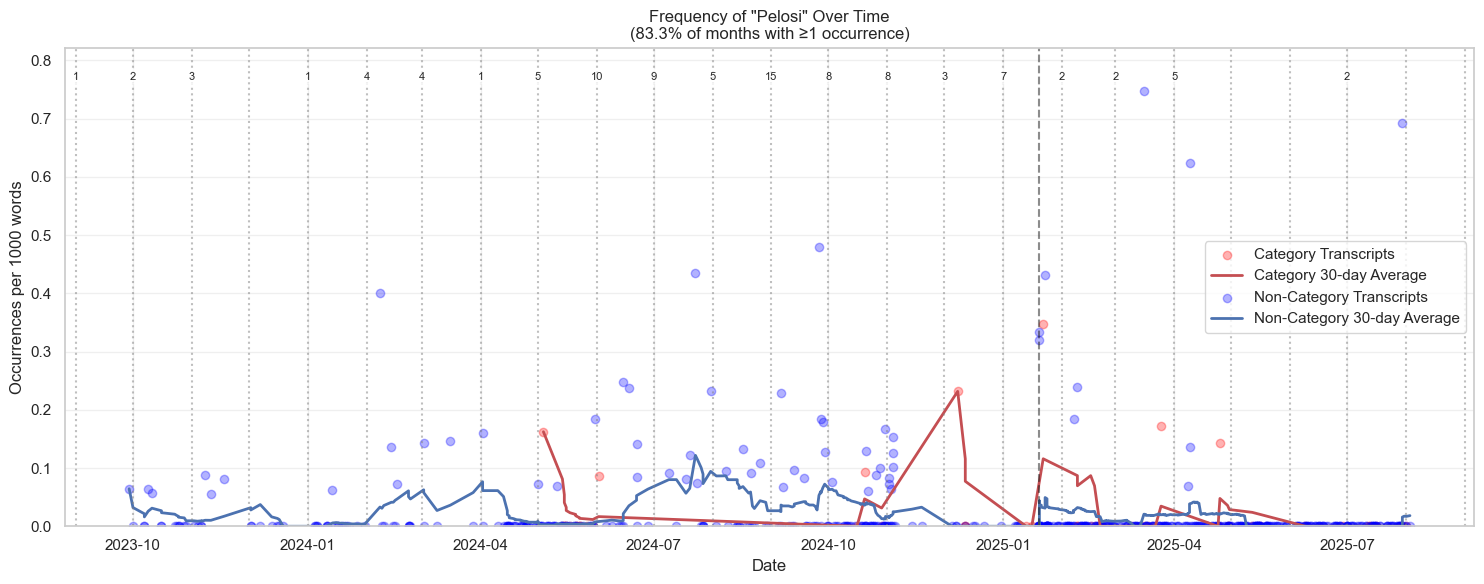

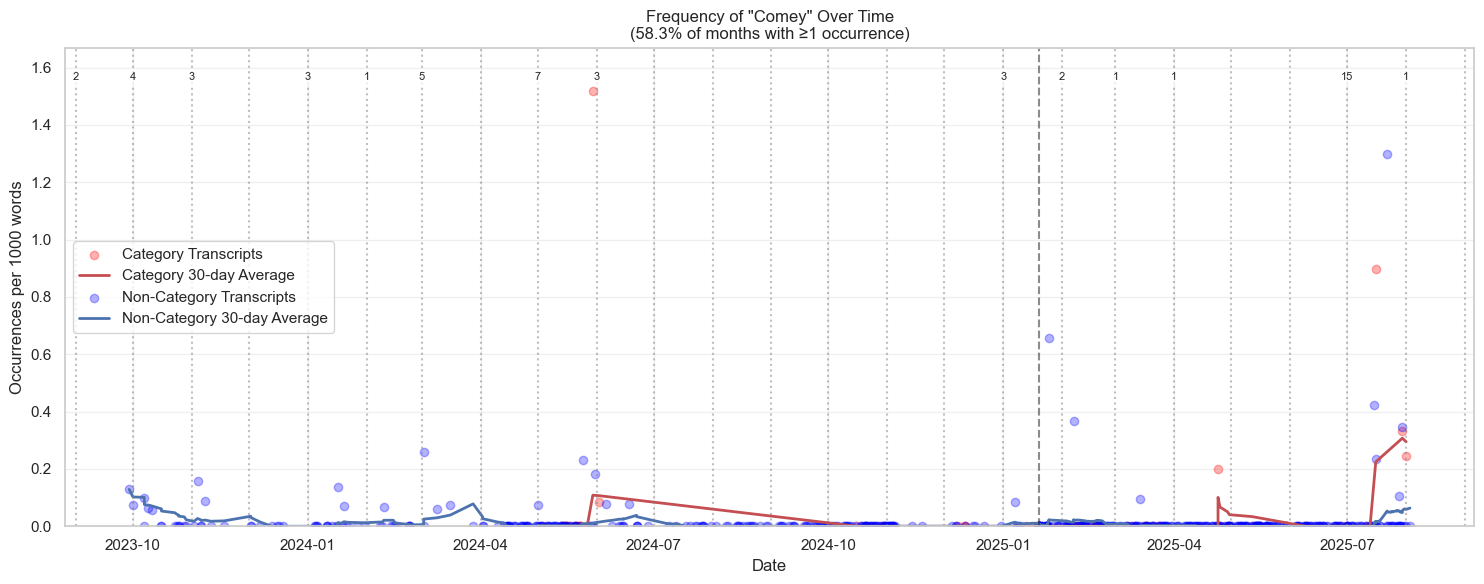

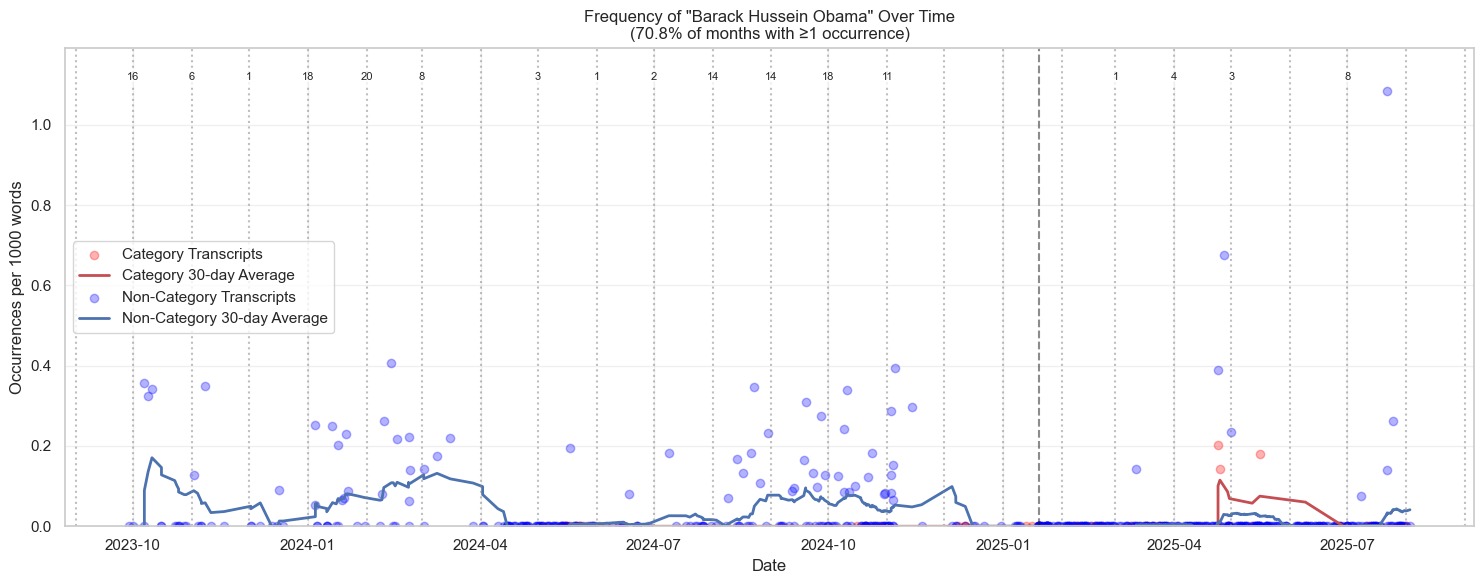

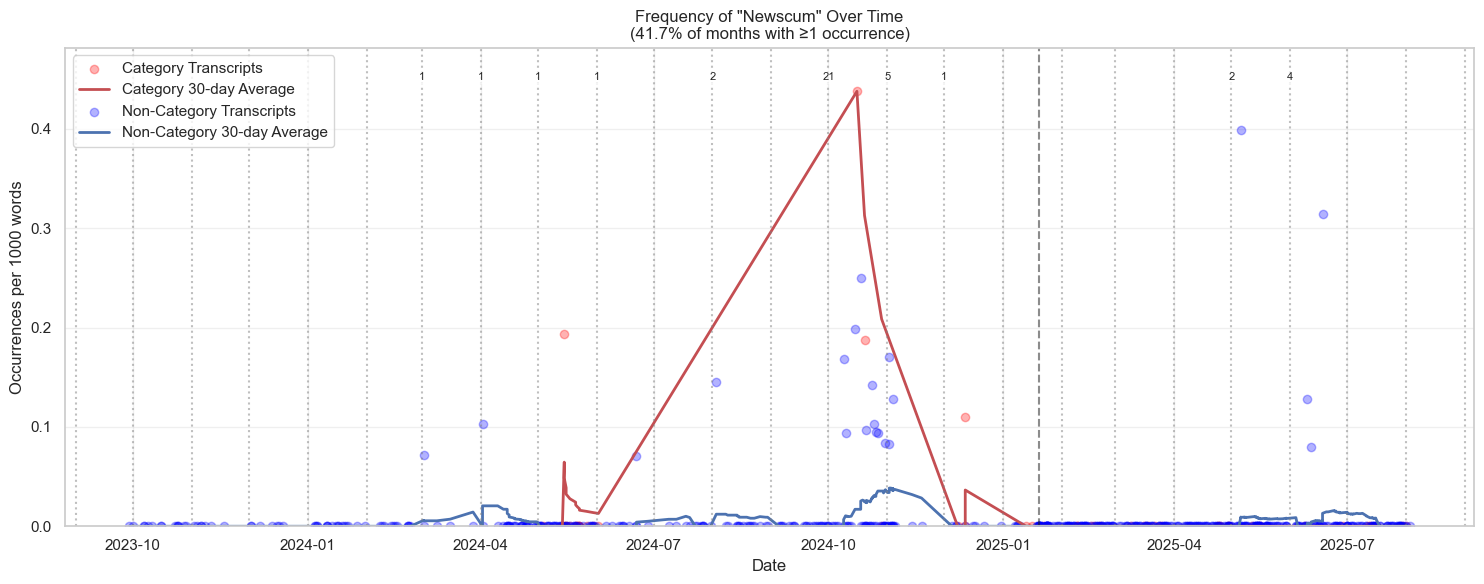

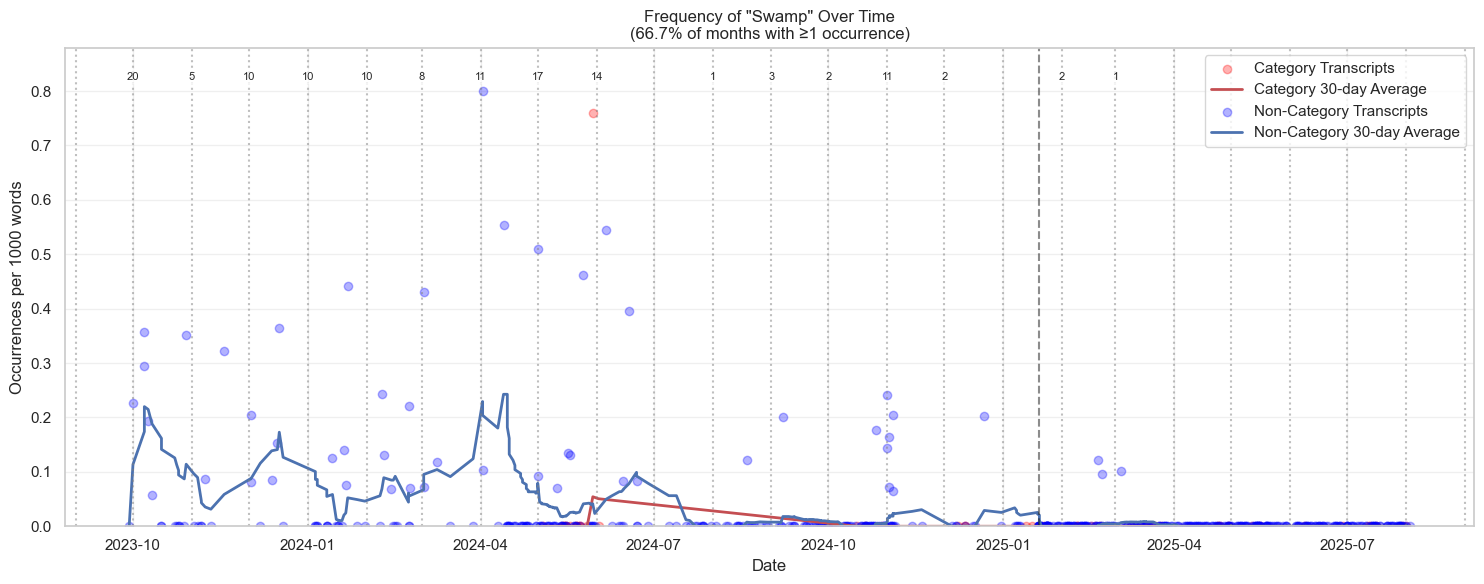

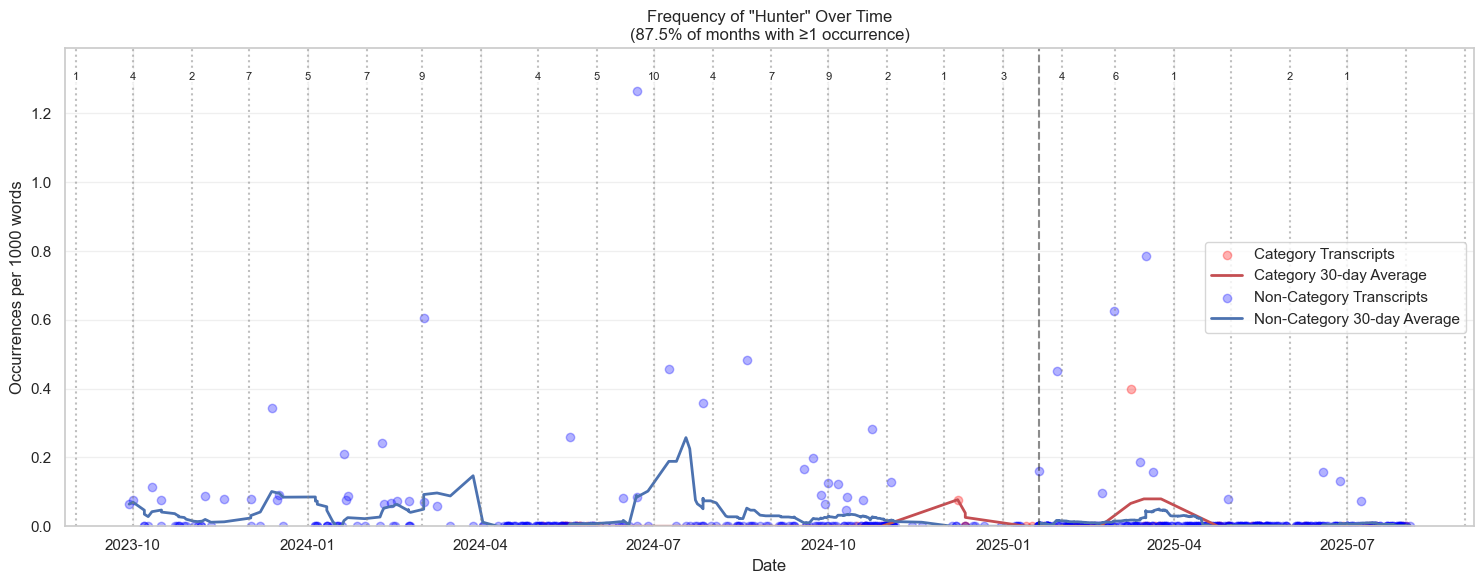

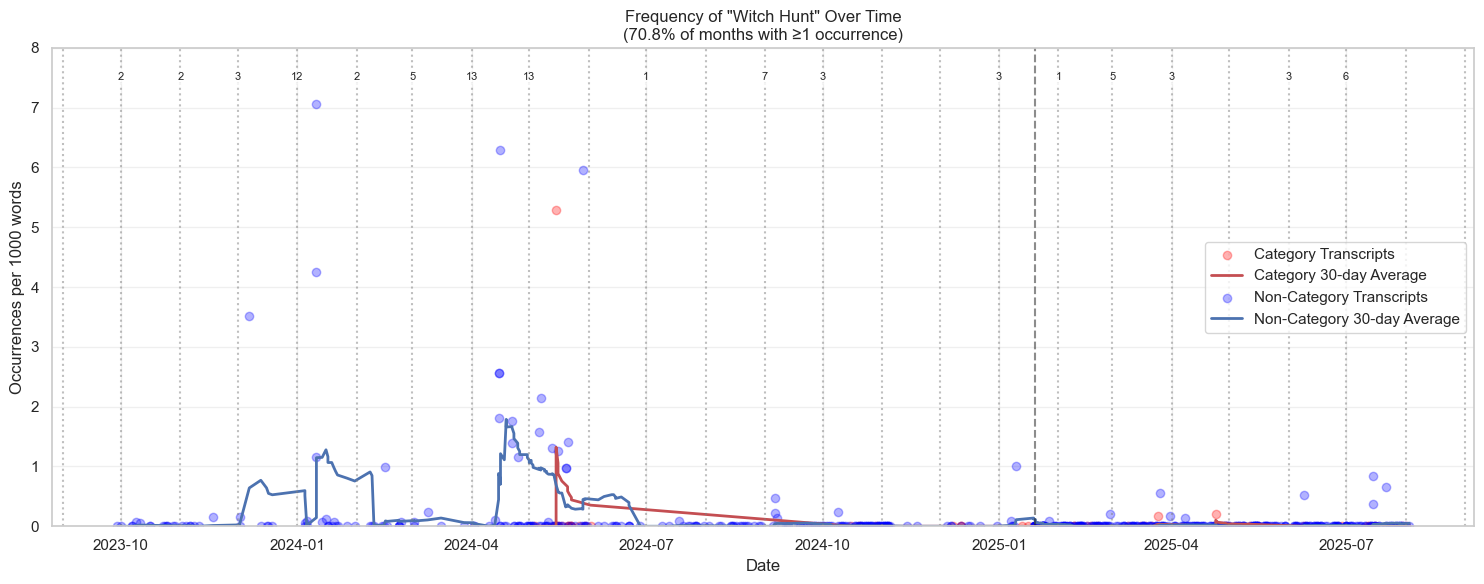

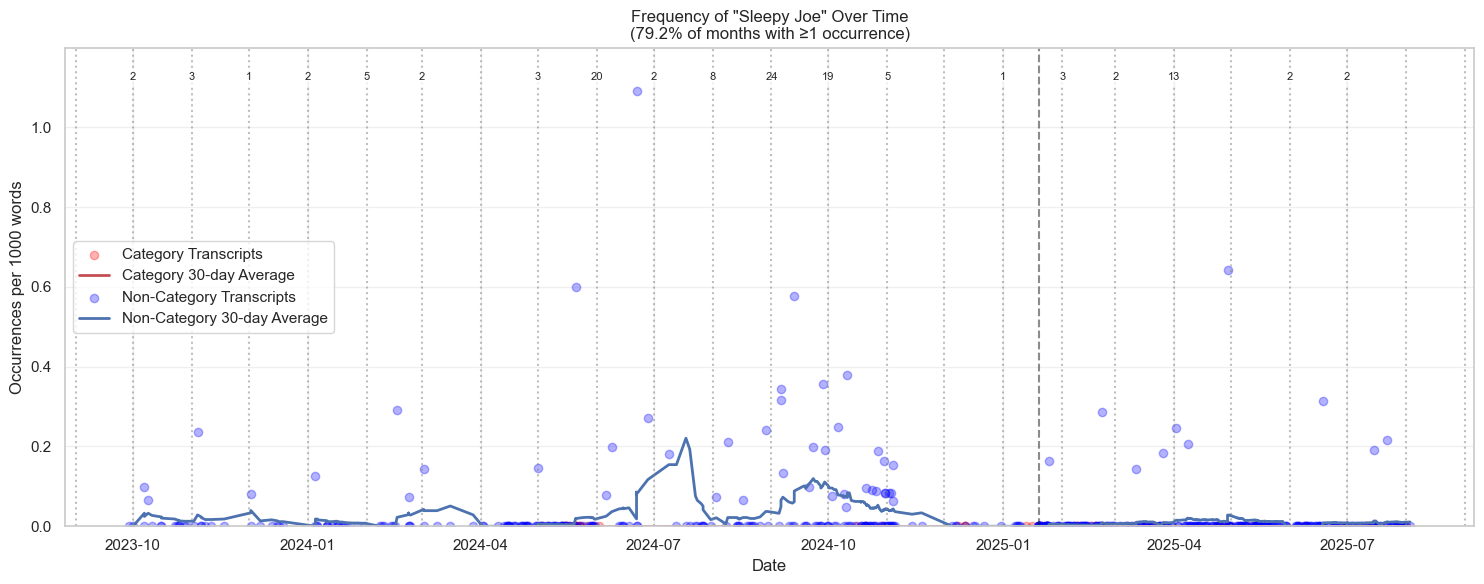

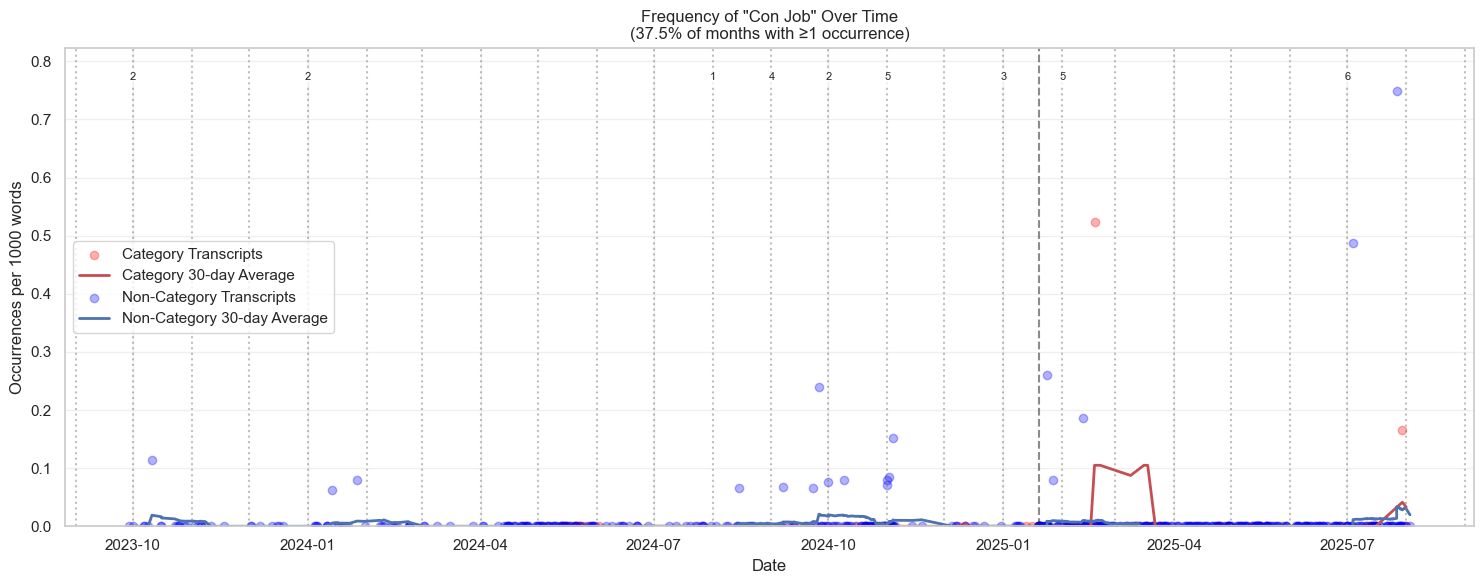

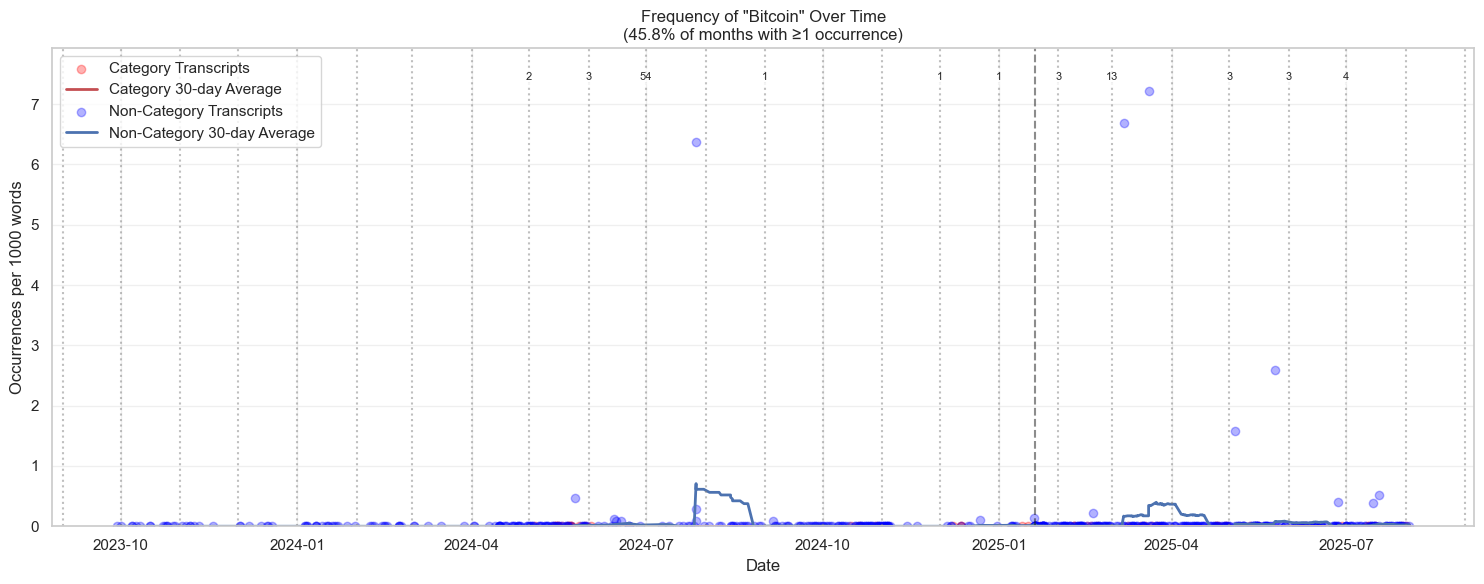

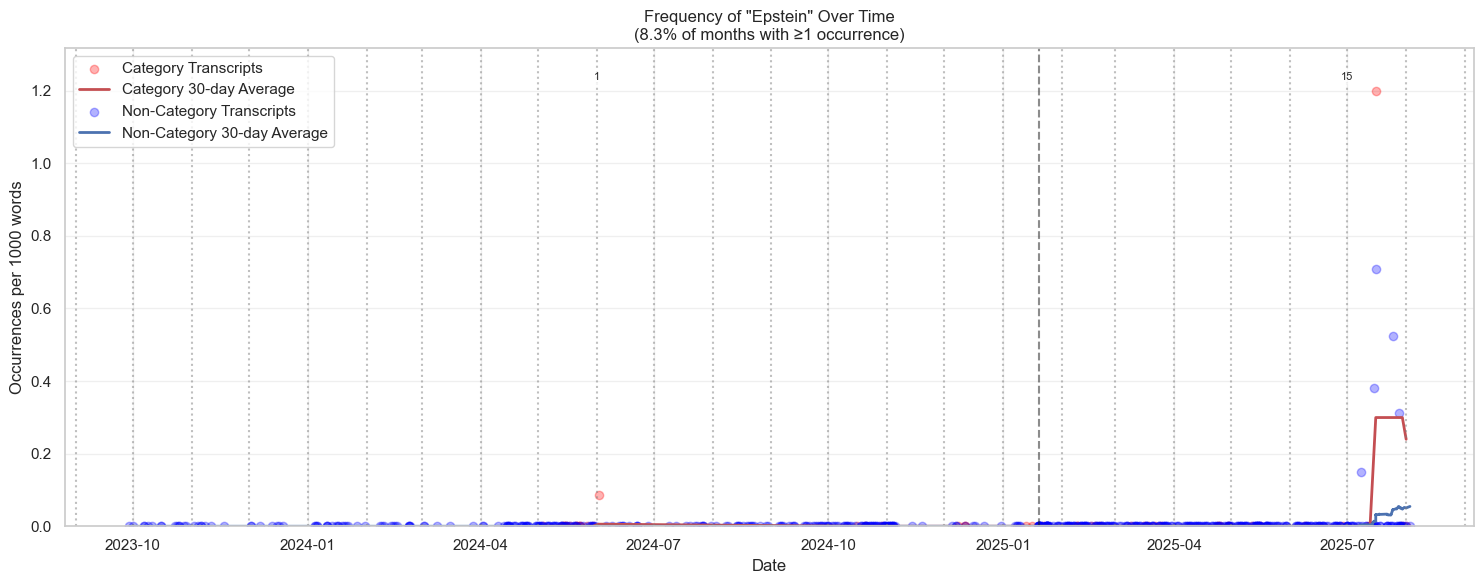

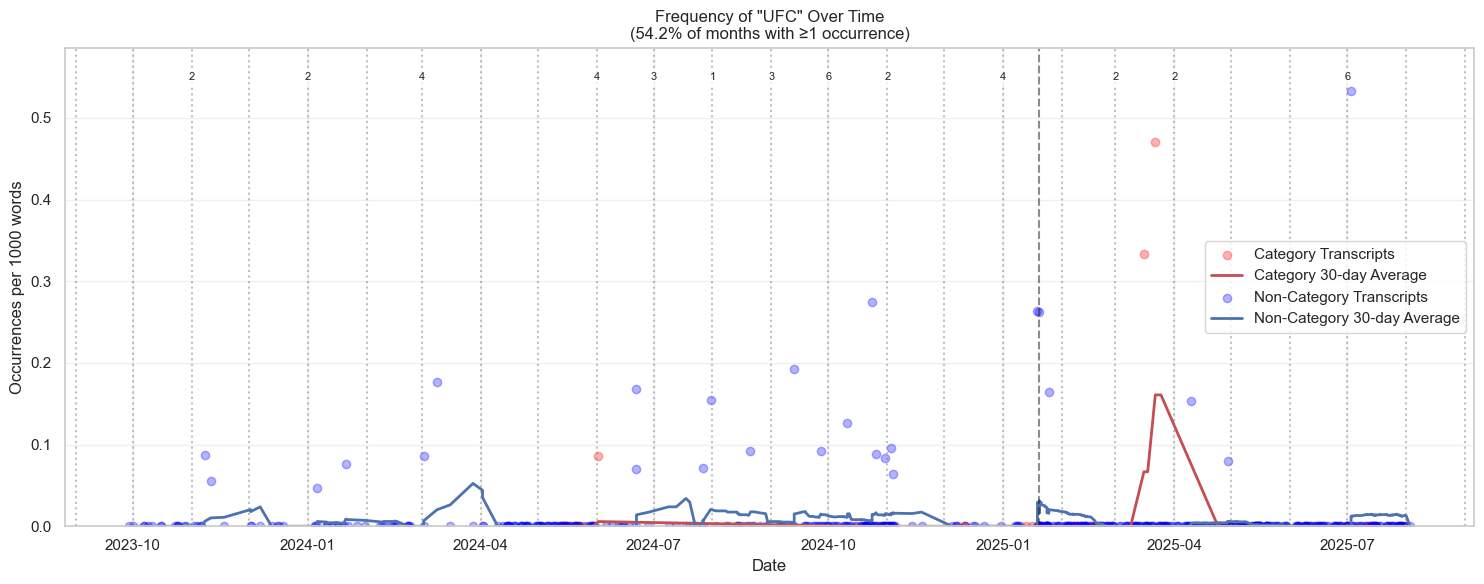

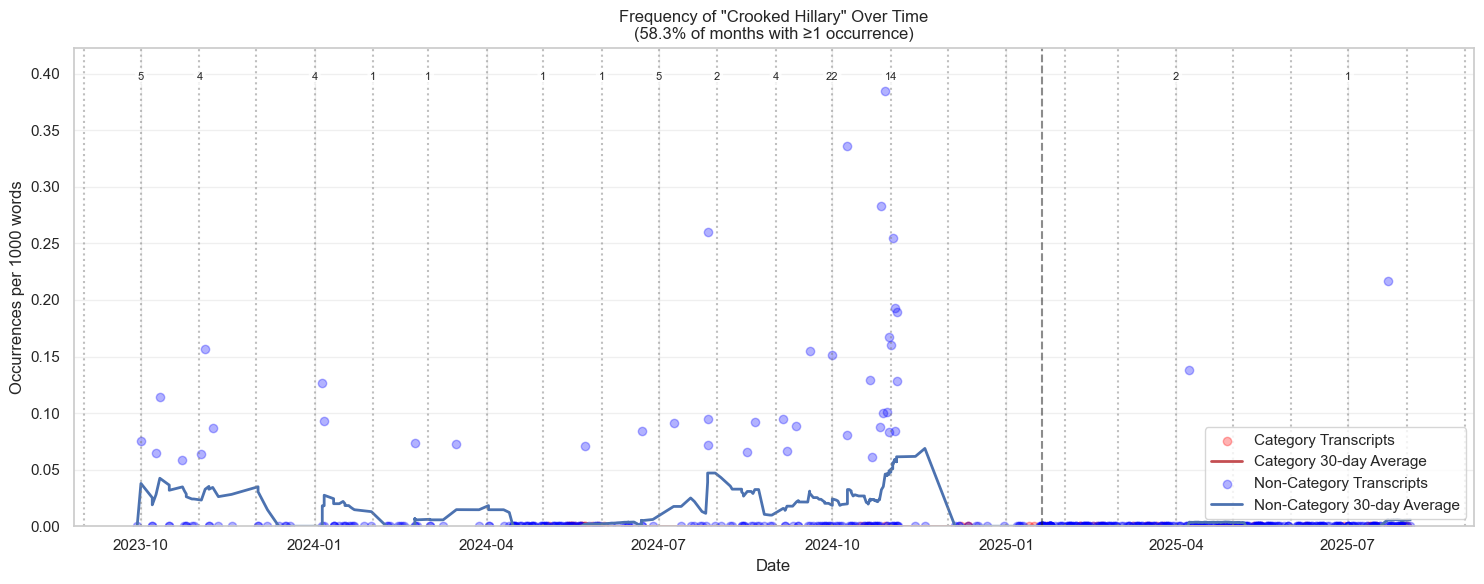

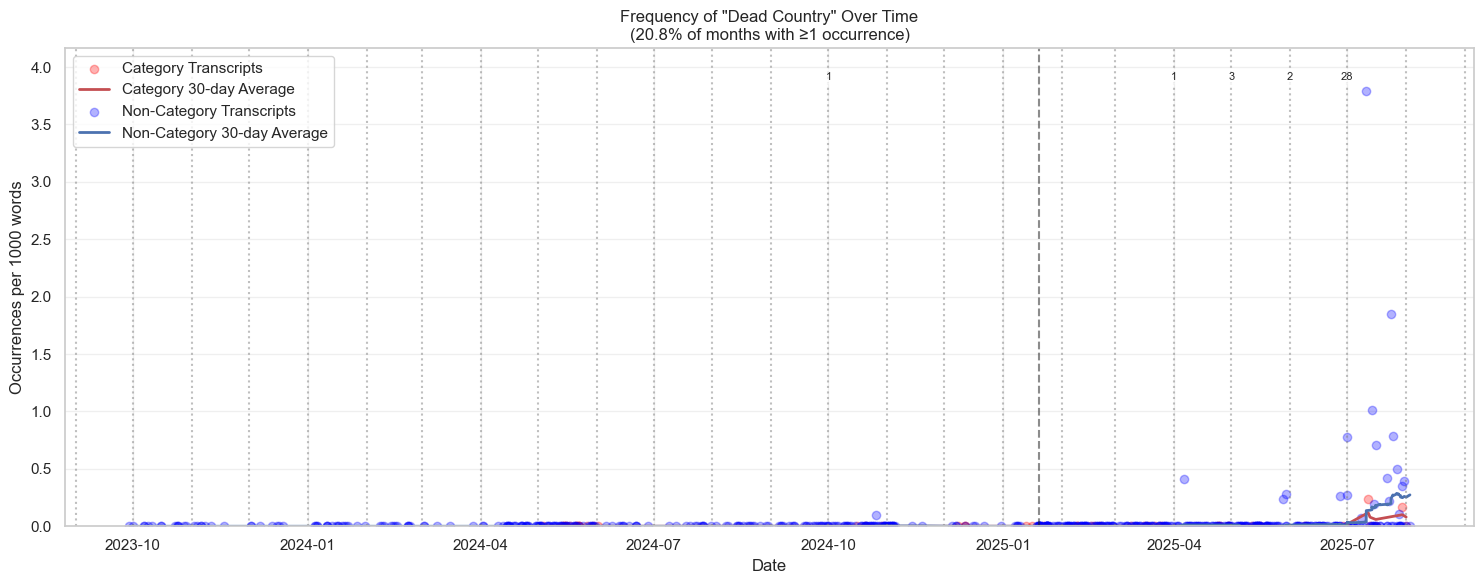

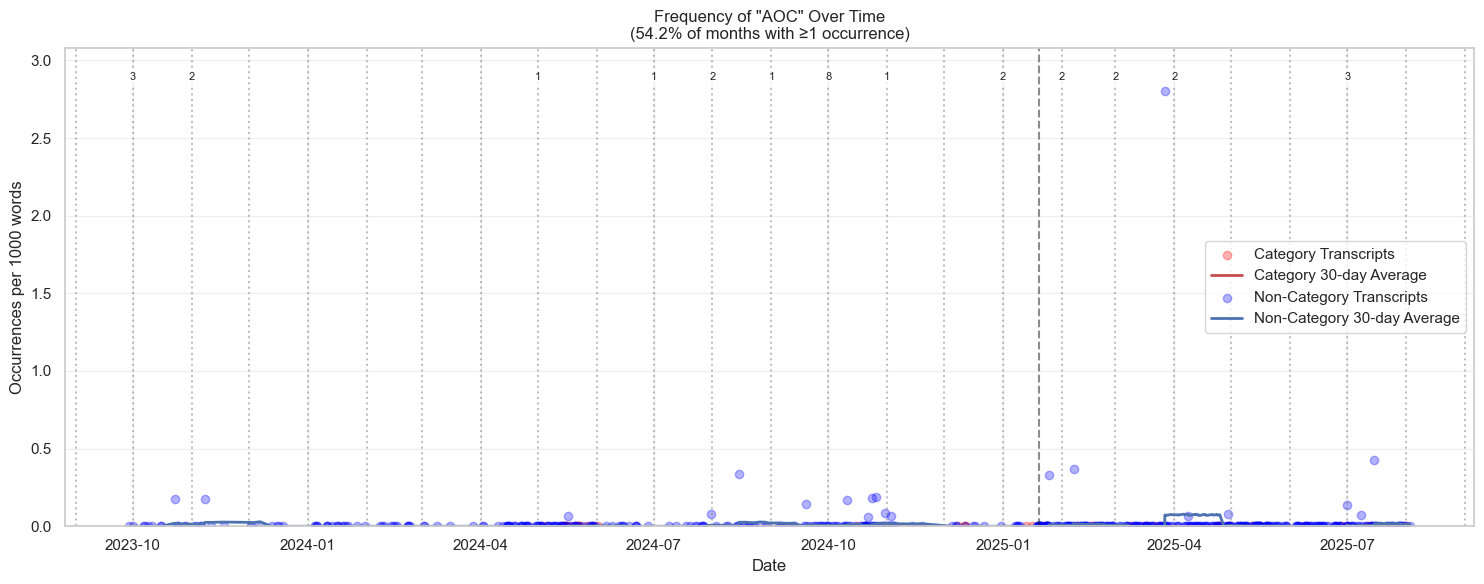

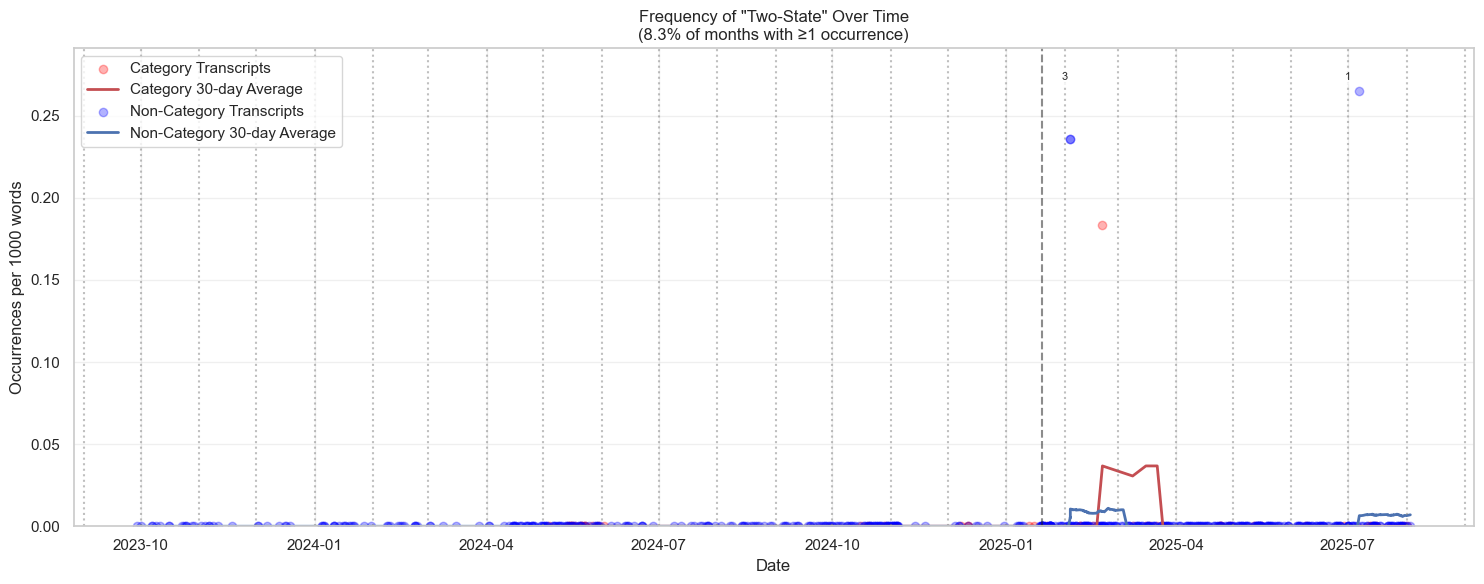

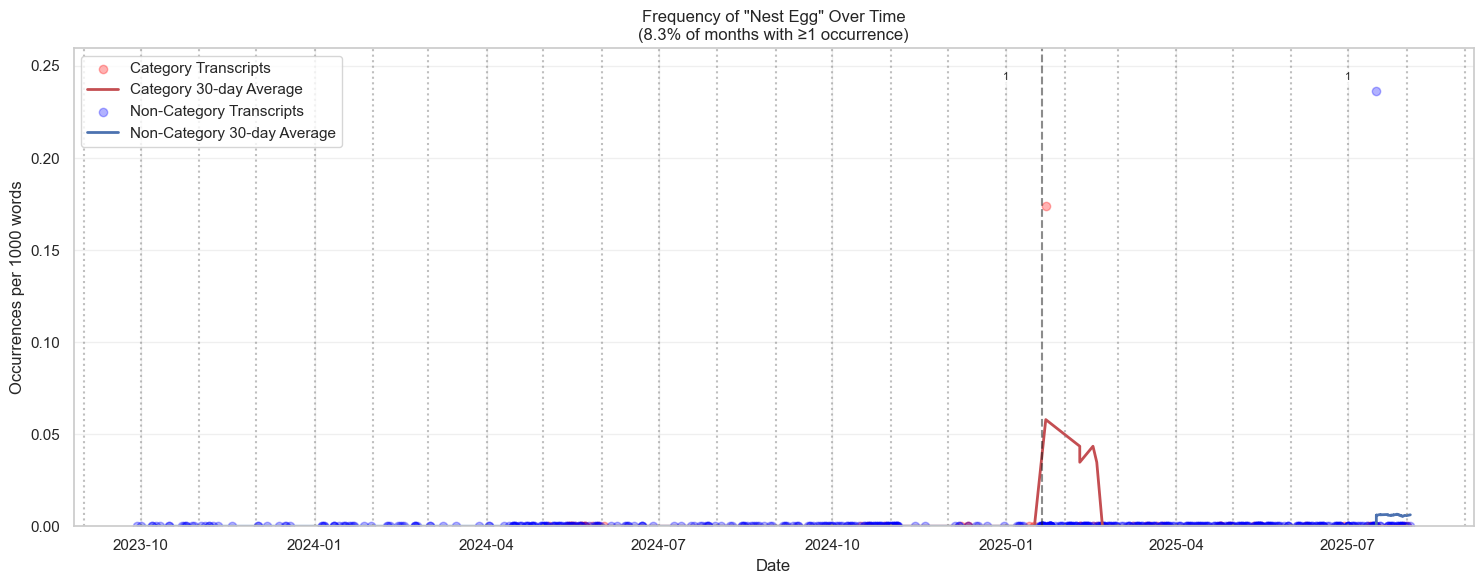

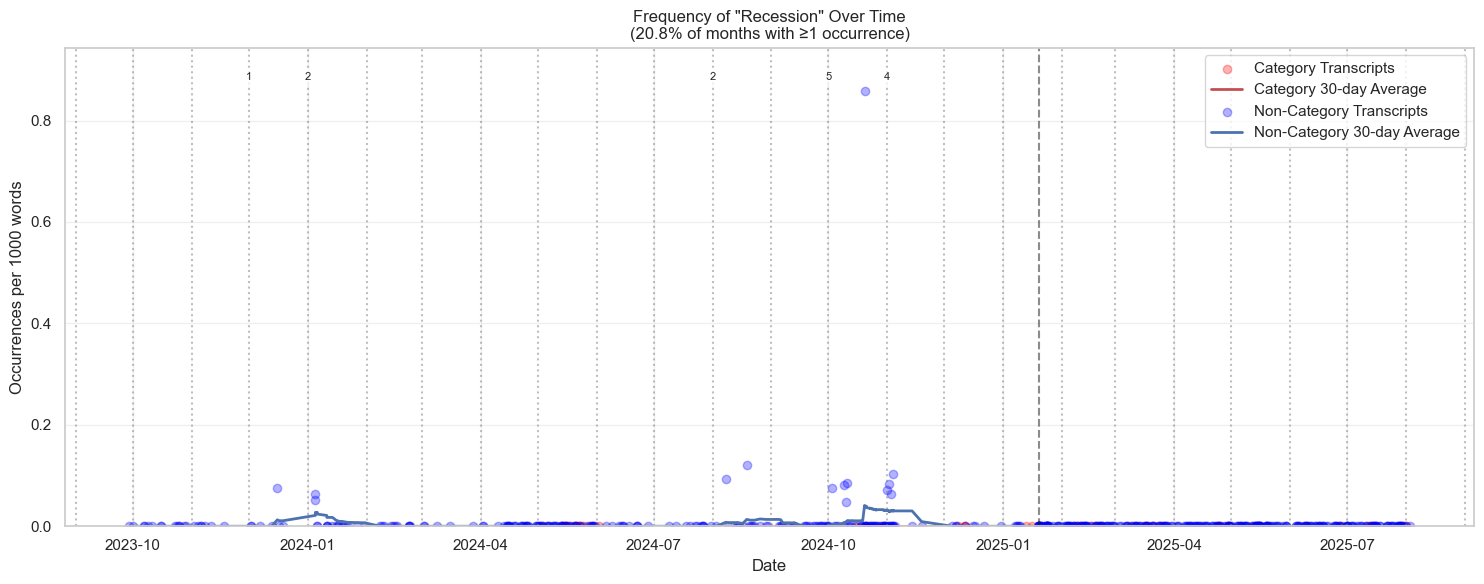

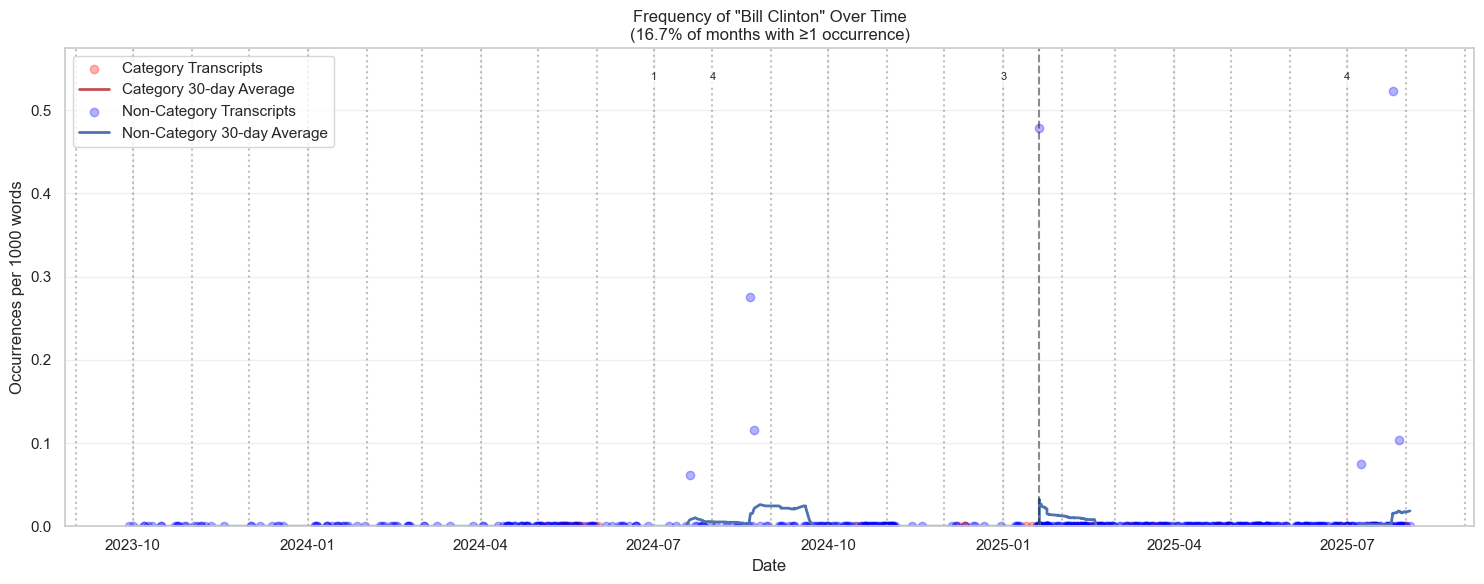

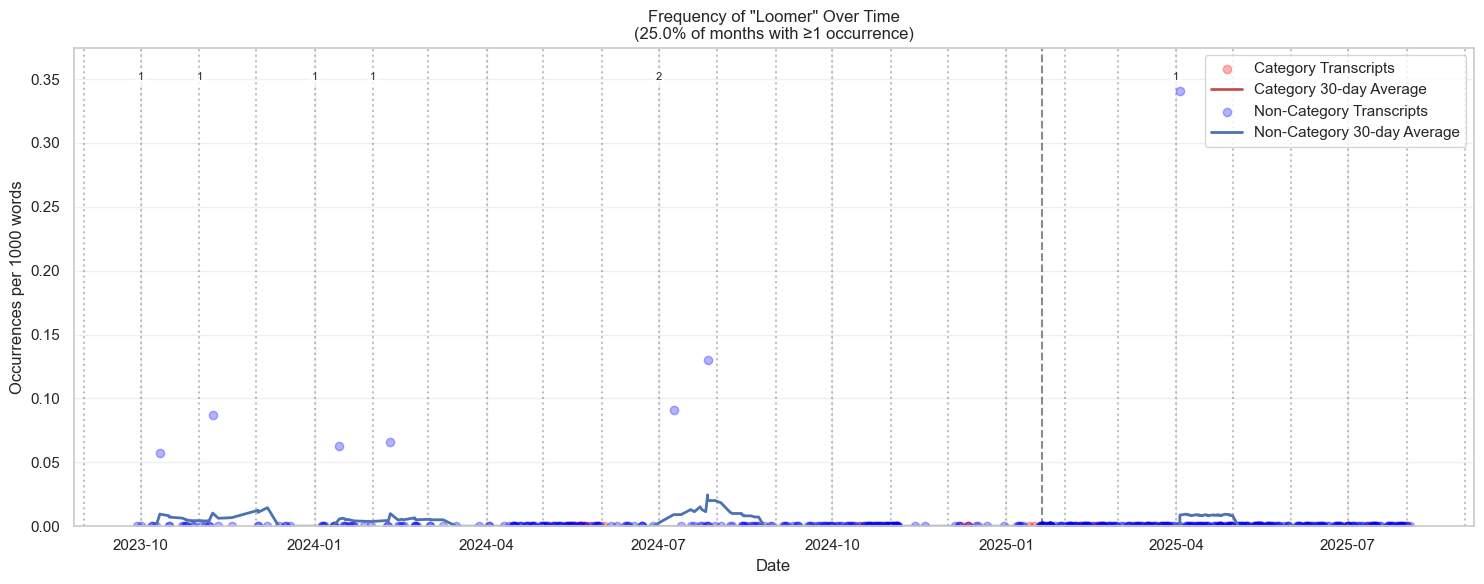

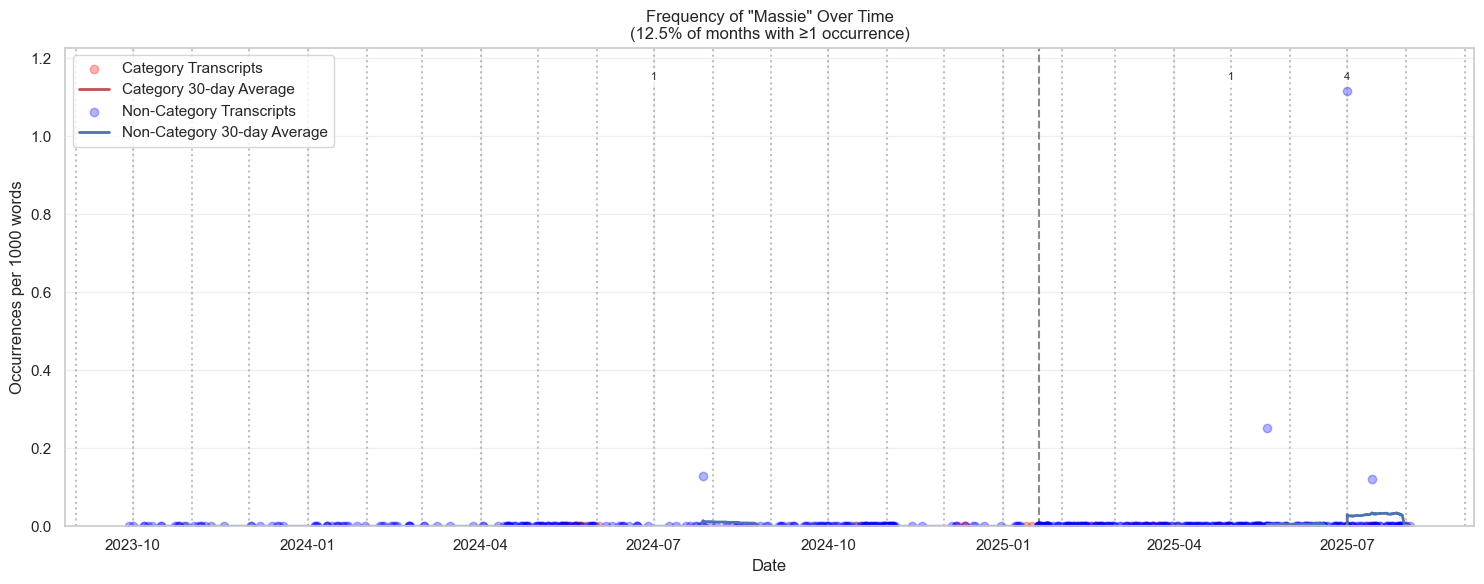

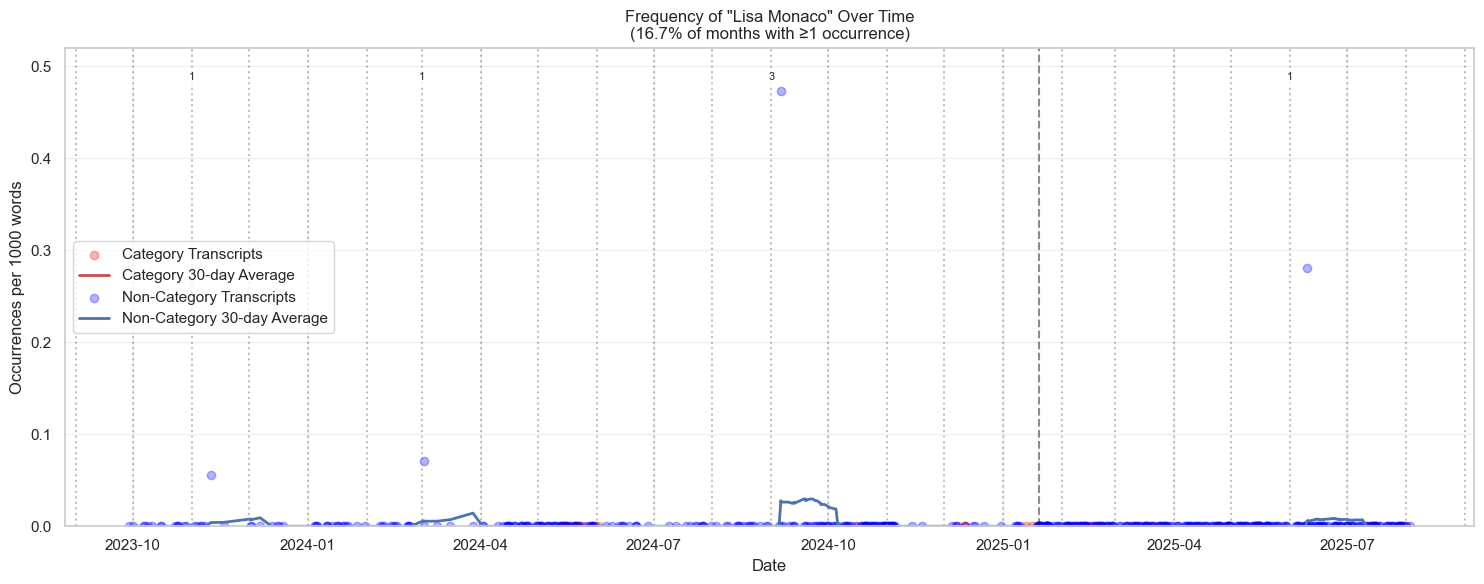

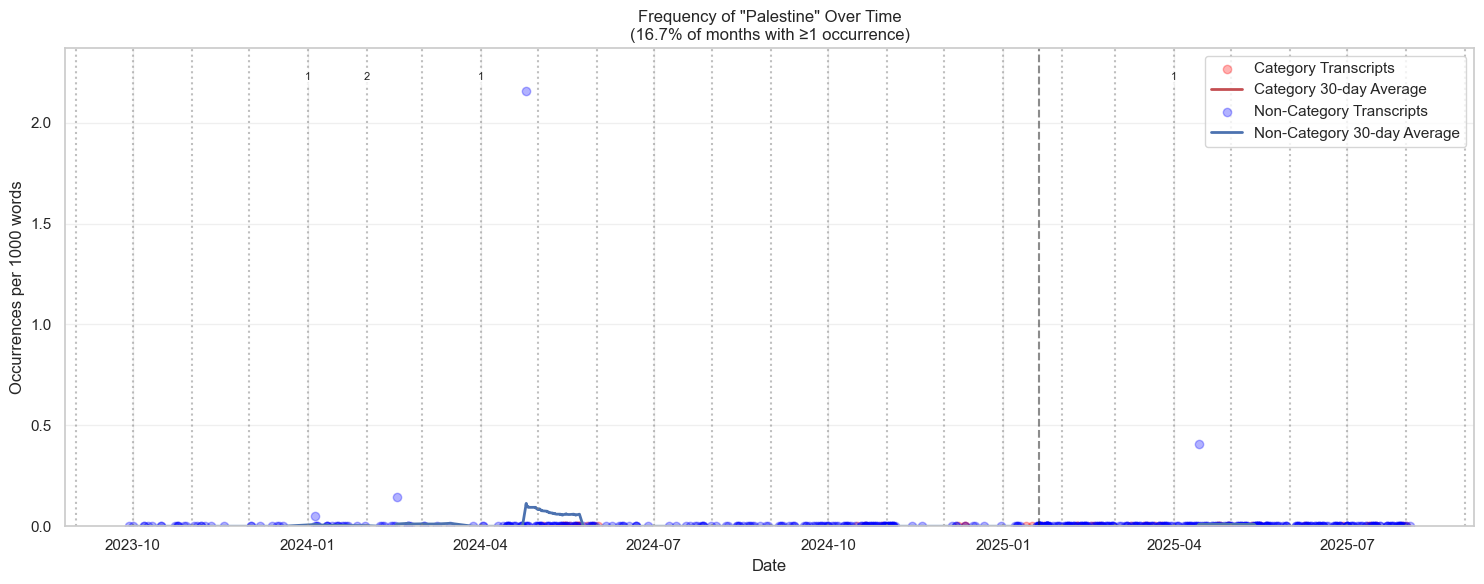

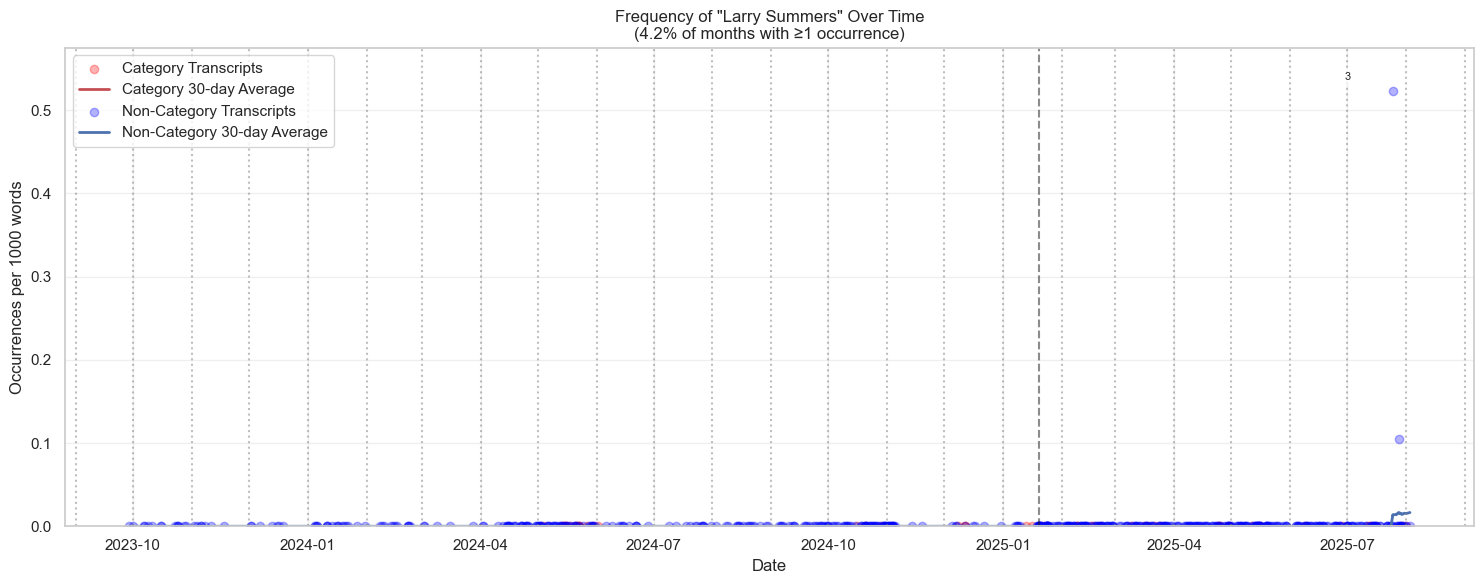

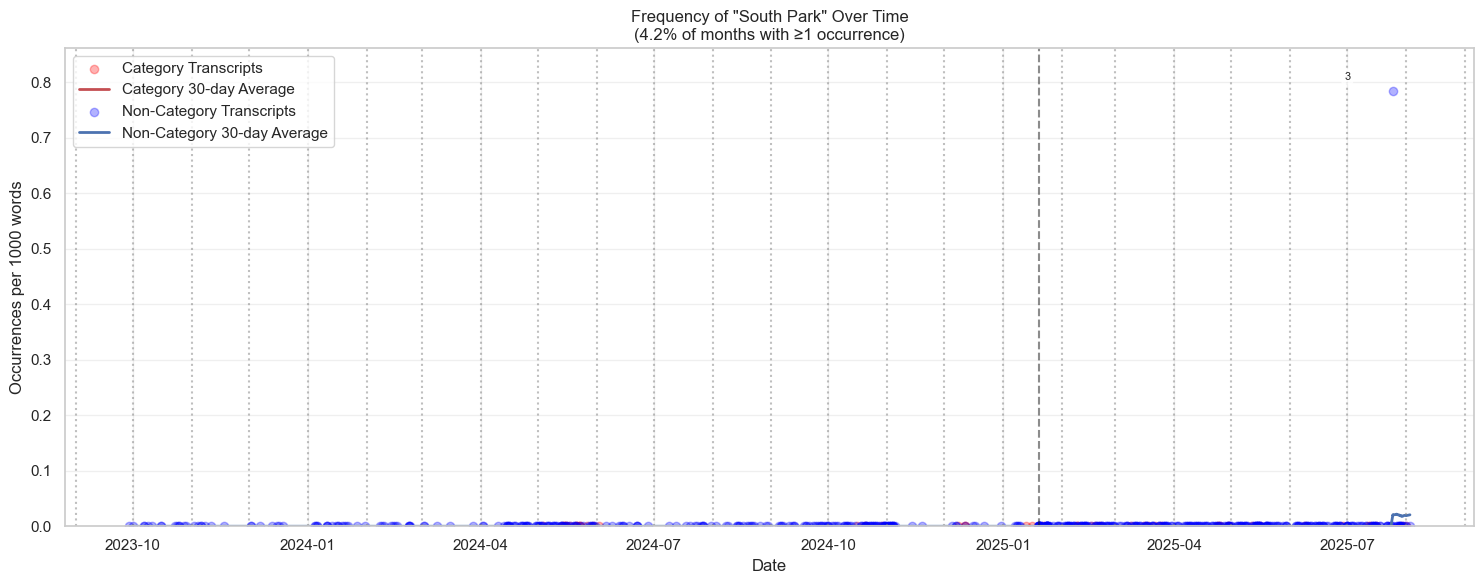

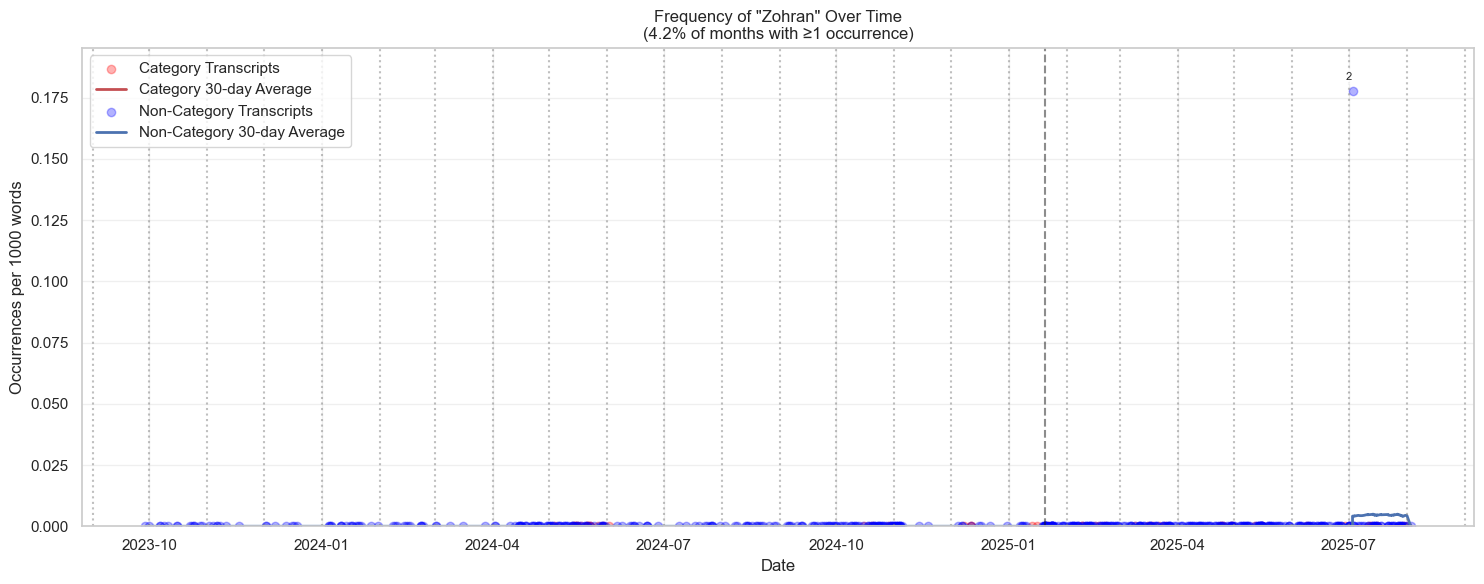

/var/folders/_t/ds12gpdx0qb6km94c759_z9m0000gn/T/ipykernel_75800/1707391992.py:81: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, ymax)


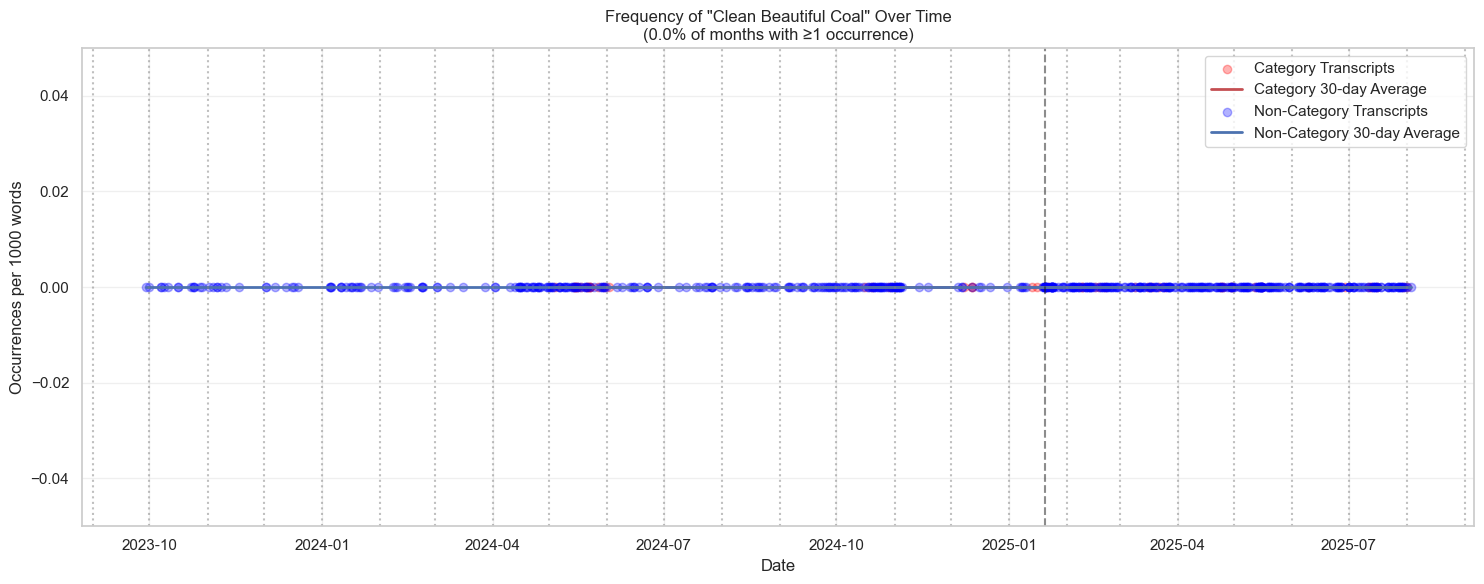

/var/folders/_t/ds12gpdx0qb6km94c759_z9m0000gn/T/ipykernel_75800/1707391992.py:81: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, ymax)


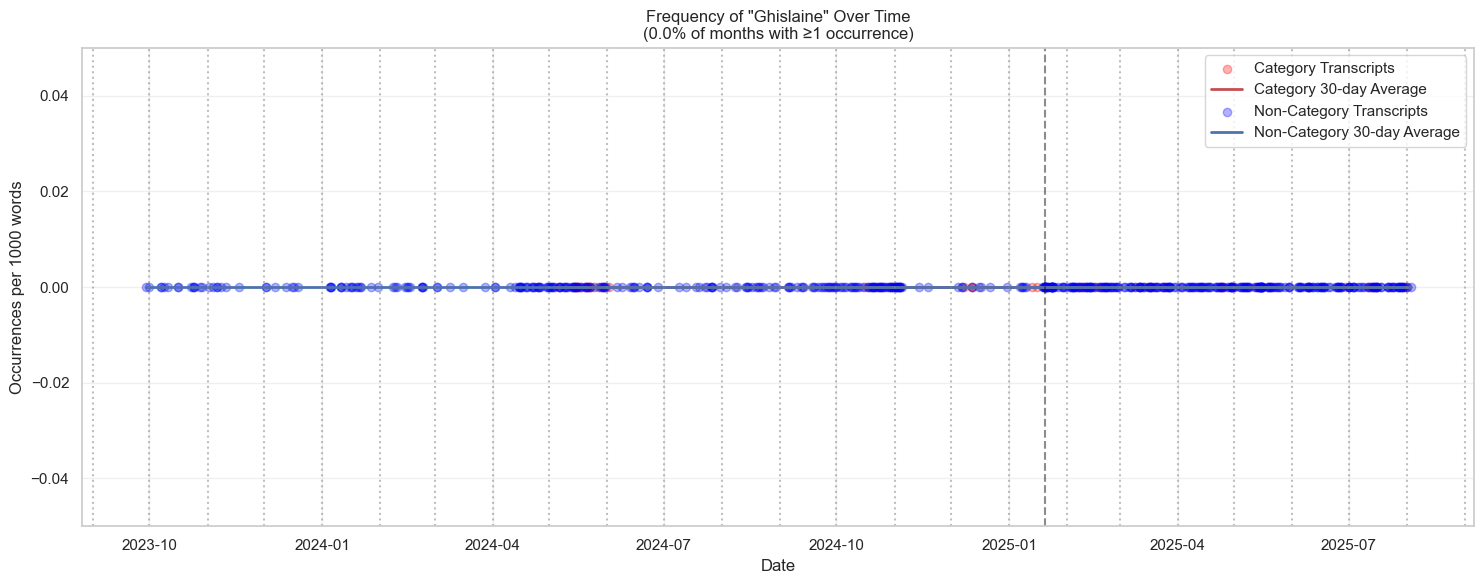

/var/folders/_t/ds12gpdx0qb6km94c759_z9m0000gn/T/ipykernel_75800/1707391992.py:81: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, ymax)


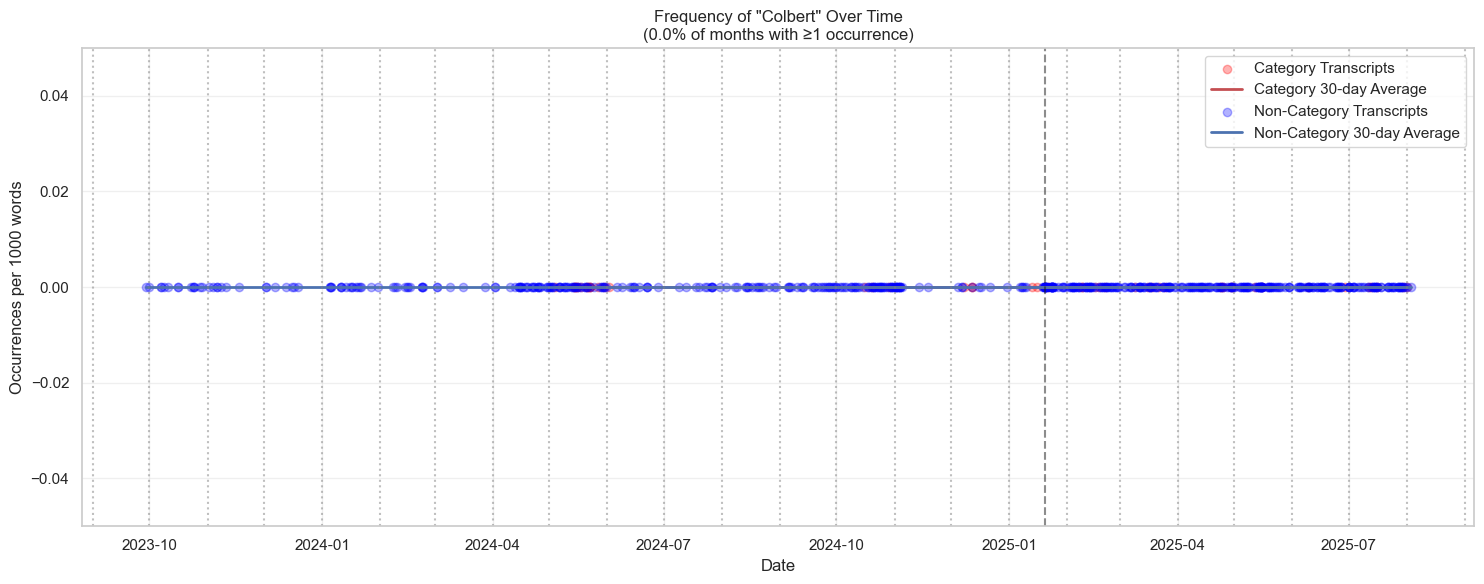

/var/folders/_t/ds12gpdx0qb6km94c759_z9m0000gn/T/ipykernel_75800/1707391992.py:81: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, ymax)


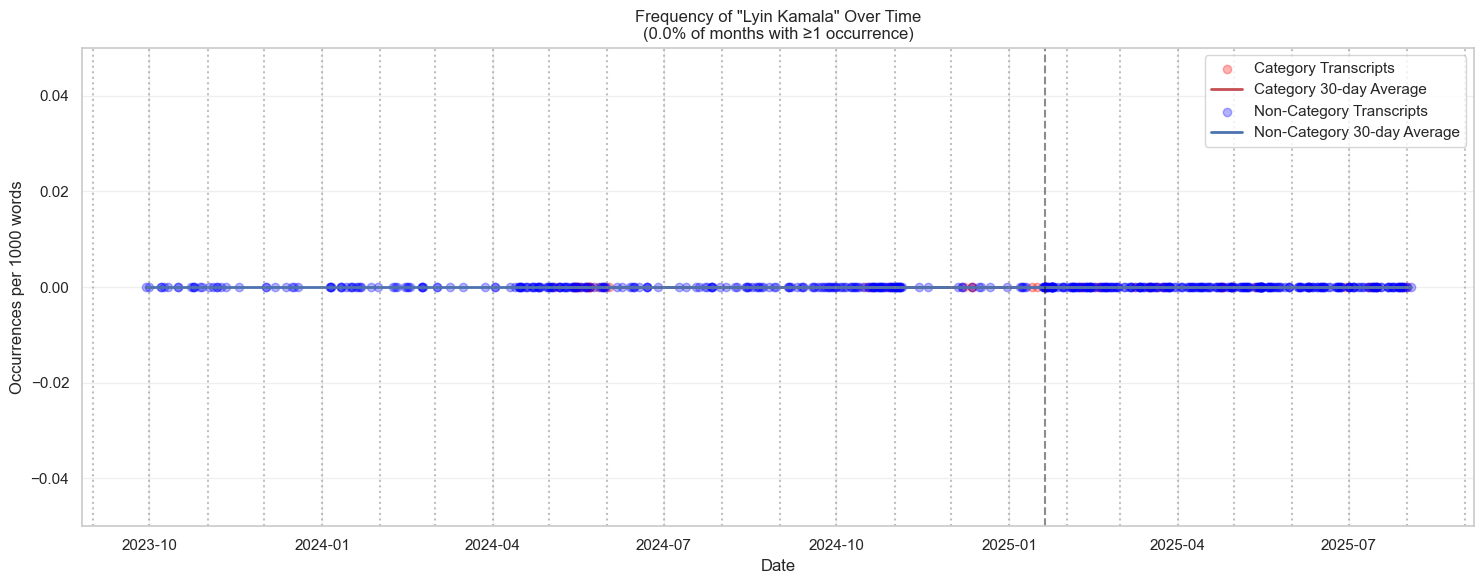

/var/folders/_t/ds12gpdx0qb6km94c759_z9m0000gn/T/ipykernel_75800/1707391992.py:81: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, ymax)


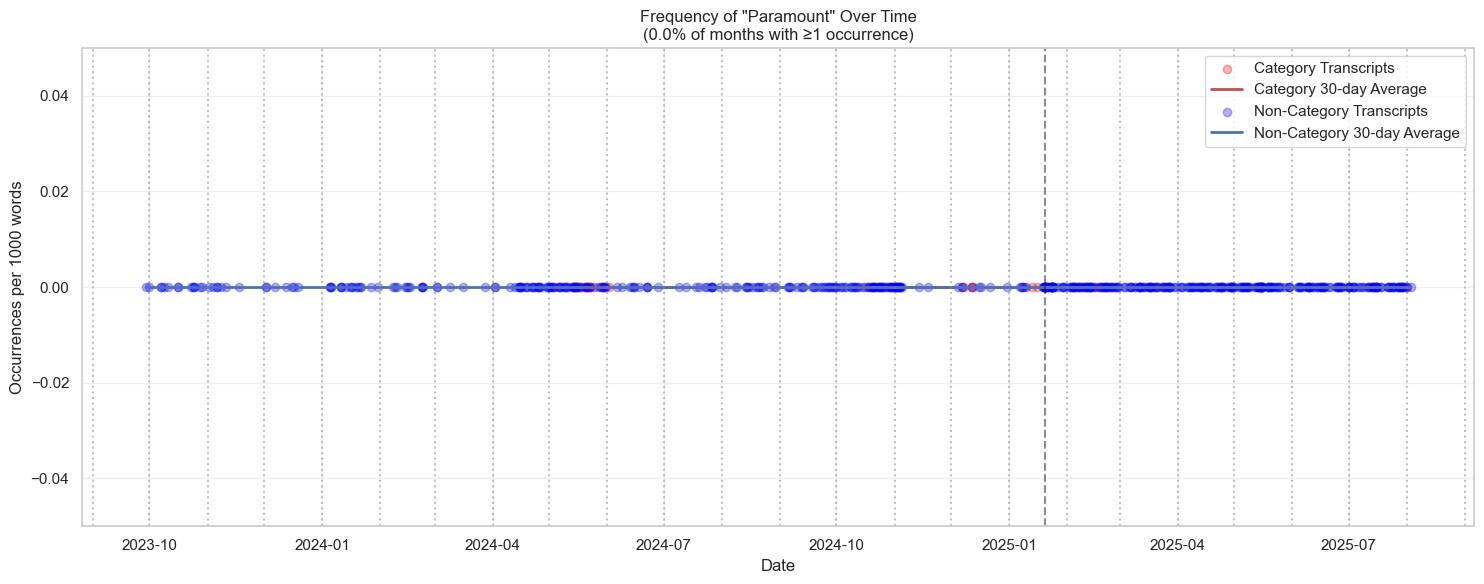

In [18]:
def plot_phrase_frequency_over_time(df_category, df_non_category, phrase, window=30):
    """Plot the frequency of a phrase over time with separate lines for category and non-category"""
    plt.figure(figsize=(15, 6))
    
    # Process category data
    df_category = df_category.copy()
    df_category[f'{phrase}_freq'] = (df_category[phrase] / df_category['text_length']) * 1000
    category_series = df_category.set_index('date')[f'{phrase}_freq']
    category_rolling = category_series.rolling(window=f'{window}D', min_periods=1).mean()
    
    # Process non-category data
    df_non_category = df_non_category.copy()
    df_non_category[f'{phrase}_freq'] = (df_non_category[phrase] / df_non_category['text_length']) * 1000
    non_category_series = df_non_category.set_index('date')[f'{phrase}_freq']
    non_category_rolling = non_category_series.rolling(window=f'{window}D', min_periods=1).mean()
    
    # Plot category data
    plt.scatter(category_series.index, category_series.values, alpha=0.3, color='red', label='Category Transcripts')
    plt.plot(category_rolling.index, category_rolling.values, 'r-', linewidth=2, label=f'Category {window}-day Average')
    
    # Plot non-category data
    plt.scatter(non_category_series.index, non_category_series.values, alpha=0.3, color='blue', label='Non-Category Transcripts')
    plt.plot(non_category_rolling.index, non_category_rolling.values, 'b-', linewidth=2, label=f'Non-Category {window}-day Average')
    
    plt.title(f'Frequency of "{phrase}" Over Time')
    plt.xlabel('Date')
    plt.ylabel('Occurrences per 1000 words')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add vertical line for inauguration
    plt.axvline(x=INAUGURATION_DATE, color='k', linestyle='--', alpha=0.5, label='Inauguration')
    
    # Add monthly vertical lines and counts
    combined_df = pd.concat([df_category, df_non_category])
    if not combined_df.empty:
        date_range = pd.date_range(
            start=combined_df['date'].min().replace(day=1),
            end=combined_df['date'].max() + pd.DateOffset(months=1),
            freq='MS'  # Month start
        )
        
        # Calculate monthly statistics
        combined_df['year_month'] = combined_df['date'].dt.to_period('M')
        monthly_stats = combined_df.groupby('year_month').agg({
            phrase: 'sum',
            'date': 'count'
        }).rename(columns={'date': 'transcript_count'})
        
        # Calculate % of months with 1+ occurrence
        months_with_occurrence = (monthly_stats[phrase] >= 1).sum()
        total_months = len(monthly_stats)
        pct_months_with_occurrence = (months_with_occurrence / total_months * 100) if total_months > 0 else 0
        
        # Add monthly vertical lines and counts
        for date in date_range:
            plt.axvline(x=date, color='gray', linestyle=':', alpha=0.5)
            
            # Get monthly count for this date
            period = date.to_period('M')
            if period in monthly_stats.index:
                monthly_count = monthly_stats.loc[period, phrase]
                if monthly_count > 0:
                    # Position text at top of plot
                    ymax = min(8, max(
                        df_category[f'{phrase}_freq'].max() if not df_category.empty else 0,
                        df_non_category[f'{phrase}_freq'].max() if not df_non_category.empty else 0
                    ) * 1.1)
                    plt.text(date, ymax * 0.95, str(int(monthly_count)), 
                            ha='center', va='top', fontsize=8, 
                            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))
        
        # Add percentage to title
        plt.title(f'Frequency of "{phrase}" Over Time\n({pct_months_with_occurrence:.1f}% of months with ≥1 occurrence)')
    
    # Auto-adjust y-axis limit up to max of 8
    ymax = min(8, max(
        df_category[f'{phrase}_freq'].max() if not df_category.empty else 0,
        df_non_category[f'{phrase}_freq'].max() if not df_non_category.empty else 0
    ) * 1.1)  # Add 10% padding
    plt.ylim(0, ymax)
    
    plt.tight_layout()
    plt.show()

# Plot time series for all phrases, sorted by frequency
phrase_freqs = {}
for phrase in SEARCH_PHRASES.keys():
    # Calculate average frequency across all data
    category_freq = (df_category[phrase].sum() / df_category['text_length'].sum()) * 1000 if not df_category.empty and df_category['text_length'].sum() > 0 else 0
    non_category_freq = (df_non_category[phrase].sum() / df_non_category['text_length'].sum()) * 1000 if not df_non_category.empty and df_non_category['text_length'].sum() > 0 else 0
    phrase_freqs[phrase] = (category_freq + non_category_freq) / 2

# Sort phrases by frequency and plot
for phrase in sorted(phrase_freqs, key=phrase_freqs.get, reverse=True):
    plot_phrase_frequency_over_time(df_category, df_non_category, phrase)

In [ ]:
# Calculate expected length from the chosen category
expected_length = df_category['text_length'].mean()
print(f"Expected length from category data: {expected_length:.0f} words")


Expected length from category data: 4367 words


## Poisson Predictions

The most naive approach is to use the past frequency of a phrase over a given time period to forecast the probability of a phrase occurring during the expected length of a future speech. Using the Poisson distribution, we assume each word is independent and identically distributed. This allows us to compute threshold probabilities for a phrase occurring a given number of times, which can be compared to the prediction market's implied probability. However, this approach does not account for the clear dependence between words in a speech. This approach can still be useful for analyzing mentions where mostly independent occurrences might be expected (America, God, etc.) 

In [ ]:
def calculate_poisson_predictions(df, avg_length):
    """Calculate predictions with likelihoods using Poisson distribution"""
    predictions = []
    
    for phrase in SEARCH_PHRASES.keys():
        # Calculate rate per word
        total_occurrences = df[phrase].sum()
        total_words = df['text_length'].sum()
        rate_per_word = total_occurrences / total_words
        
        # Expected occurrences in SOTU
        expected = rate_per_word * avg_length
        
        # Calculate likelihoods using Poisson PMF
        def poisson_ge_k(lambda_, k):
            return 1 - stats.poisson.cdf(k-1, lambda_)
        
        predictions.append({
            'Phrase': phrase,
            'Expected': expected,
            'Historical Rate': rate_per_word * 1000,  # per 1000 words
            'Total Historical': total_occurrences,
            'P(≥1)': poisson_ge_k(expected, 1),
            'P(≥3)': poisson_ge_k(expected, 3),
            'P(≥4)': poisson_ge_k(expected, 4),
            'P(≥5)': poisson_ge_k(expected, 5),
            'P(≥15)': poisson_ge_k(expected, 15)
        })
    
    return pd.DataFrame(predictions)

length = 10000

# Calculate predictions from different data sources
predictions_all = calculate_poisson_predictions(df, length)
predictions_speeches = calculate_poisson_predictions(df_speech, length)
predictions_post_all = calculate_poisson_predictions(pd.concat([df_nonspeech_post, df_speech_post]), length)

# Format the tables
def format_prediction_table(df, source):
    formatted = df.copy()
    formatted = formatted.round(2)
    formatted['P(≥1)'] = formatted['P(≥1)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥3)'] = formatted['P(≥3)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥4)'] = formatted['P(≥4)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥5)'] = formatted['P(≥5)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥15)'] = formatted['P(≥15)'].apply(lambda x: f"{x:.1%}")
    
    return formatted[[
        'Phrase', 'Expected',
        'P(≥1)', 'P(≥3)', 'P(≥4)', 'P(≥5)', 'P(≥15)',
        'Historical Rate', 'Total Historical'
    ]].sort_values('Expected', ascending=False)

print("Predictions based on all appearances:")
display(format_prediction_table(predictions_all, 'all'))

print("\nPredictions based on all speeches:")
display(format_prediction_table(predictions_speeches, 'post-inauguration-speeches'))

print("\nPredictions based on all post-inauguration appearances:")
display(format_prediction_table(predictions_post_all, 'post-inauguration-all'))

Predictions based on all appearances:


Phrase  Expected   P(≥1)   P(≥3)   P(≥4)   P(≥5) P(≥15)  \
26              Border     13.95  100.0%  100.0%  100.0%  100.0%  42.0%   
21               Biden     13.68  100.0%  100.0%  100.0%  100.0%  40.0%   
46              Kamala     10.79  100.0%  100.0%   99.0%   98.0%  13.0%   
24            Election      9.95  100.0%  100.0%   99.0%   97.0%   8.0%   
15               China      9.32  100.0%  100.0%   98.0%   95.0%   5.0%   
12              Energy      5.62  100.0%   92.0%   81.0%   66.0%   0.0%   
8            Inflation      5.53  100.0%   91.0%   80.0%   65.0%   0.0%   
39              Russia      5.45  100.0%   91.0%   79.0%   64.0%   0.0%   
33             Ukraine      3.22   96.0%   63.0%   40.0%   22.0%   0.0%   
23              Israel      2.97   95.0%   57.0%   35.0%   18.0%   0.0%   
4              Economy      2.96   95.0%   57.0%   34.0%   18.0%   0.0%   
30                 Oil      2.66   93.0%   50.0%   28.0%   13.0%   0.0%   
5              Nuclear      2.60   93.0%   48.0%   26.0%   12.0%   0.0%   
32                Elon      2.05   87.0%   34.0%   15.0%    6.0%   0.0%   
3                Steel      2.03   87.0%   33.0%   15.0%    6.0%   0.0%   
10               Peace      1.86   84.0%   29.0%   12.0%    4.0%   0.0%   
29              Canada      1.76   83.0%   26.0%   10.0%    3.0%   0.0%   
16               India      0.92   60.0%    7.0%    1.0%    0.0%   0.0%   
28               Japan      0.90   59.0%    6.0%    1.0%    0.0%   0.0%   
17         Immigration      0.79   55.0%    5.0%    1.0%    0.0%   0.0%   
22                Woke      0.78   54.0%    4.0%    1.0%    0.0%   0.0%   
0                   EU      0.75   53.0%    4.0%    1.0%    0.0%   0.0%   
40       Supreme Court      0.72   51.0%    4.0%    1.0%    0.0%   0.0%   
31         Transgender      0.72   51.0%    4.0%    1.0%    0.0%   0.0%   
14                  AI      0.69   50.0%    3.0%    1.0%    0.0%   0.0%   
43              Golden      0.67   49.0%    3.0%    0.0%    0.0%   0.0%   
2           Reciprocal      0.65   48.0%    3.0%    0.0%    0.0%   0.0%   
36            Sanction      0.65   48.0%    3.0%    0.0%    0.0%   0.0%   
19             Bitcoin      0.60   45.0%    2.0%    0.0%    0.0%   0.0%   
13                Boom      0.59   45.0%    2.0%    0.0%    0.0%   0.0%   
11                Chip      0.55   42.0%    2.0%    0.0%    0.0%   0.0%   
44          Sleepy Joe      0.38   32.0%    1.0%    0.0%    0.0%   0.0%   
27             Autopen      0.36   30.0%    1.0%    0.0%    0.0%   0.0%   
1                  Fed      0.31   27.0%    0.0%    0.0%    0.0%   0.0%   
9             Too Late      0.27   24.0%    0.0%    0.0%    0.0%   0.0%   
47                 MIT      0.22   20.0%    0.0%    0.0%    0.0%   0.0%   
7         Jobs Numbers      0.22   19.0%    0.0%    0.0%    0.0%   0.0%   
18              Genius      0.20   18.0%    0.0%    0.0%    0.0%   0.0%   
37            Ballroom      0.15   14.0%    0.0%    0.0%    0.0%   0.0%   
20  Big Beautiful Bill      0.12   11.0%    0.0%    0.0%    0.0%   0.0%   
45               MSDNC      0.12   11.0%    0.0%    0.0%    0.0%   0.0%   
48               Tesla      0.11   11.0%    0.0%    0.0%    0.0%   0.0%   
35                 DEI      0.06    6.0%    0.0%    0.0%    0.0%   0.0%   
6               Powell      0.06    6.0%    0.0%    0.0%    0.0%   0.0%   
34             Epstein      0.05    5.0%    0.0%    0.0%    0.0%   0.0%   
41              Nvidia      0.05    5.0%    0.0%    0.0%    0.0%   0.0%   
38            Earnings      0.04    4.0%    0.0%    0.0%    0.0%   0.0%   
50              Cramer      0.01    1.0%    0.0%    0.0%    0.0%   0.0%   
42             Adriana      0.00    0.0%    0.0%    0.0%    0.0%   0.0%   
49      Sydney Sweeney      0.00    0.0%    0.0%    0.0%    0.0%   0.0%   
25                 BLS      0.00    0.0%    0.0%    0.0%    0.0%   0.0%   

    Historical Rate  Total Historical  
26             1.40              4341  
21             1.37              42


Predictions based on all speeches:


Phrase  Expected   P(≥1)   P(≥3)   P(≥4)   P(≥5) P(≥15)  \
26              Border     17.24  100.0%  100.0%  100.0%  100.0%  74.0%   
21               Biden     15.74  100.0%  100.0%  100.0%  100.0%  61.0%   
46              Kamala     15.67  100.0%  100.0%  100.0%  100.0%  60.0%   
24            Election     11.20  100.0%  100.0%  100.0%   99.0%  16.0%   
15               China      9.62  100.0%  100.0%   99.0%   96.0%   6.0%   
8            Inflation      6.36  100.0%   95.0%   88.0%   76.0%   0.0%   
12              Energy      6.36  100.0%   95.0%   88.0%   76.0%   0.0%   
39              Russia      4.99   99.0%   87.0%   73.0%   56.0%   0.0%   
4              Economy      3.25   96.0%   63.0%   41.0%   23.0%   0.0%   
23              Israel      3.15   96.0%   61.0%   39.0%   21.0%   0.0%   
30                 Oil      2.72   93.0%   51.0%   29.0%   14.0%   0.0%   
33             Ukraine      2.66   93.0%   50.0%   28.0%   13.0%   0.0%   
5              Nuclear      2.06   87.0%   34.0%   15.0%    6.0%   0.0%   
32                Elon      2.01   87.0%   33.0%   14.0%    5.0%   0.0%   
3                Steel      1.90   85.0%   30.0%   13.0%    4.0%   0.0%   
10               Peace      1.39   75.0%   16.0%    5.0%    1.0%   0.0%   
22                Woke      0.97   62.0%    8.0%    2.0%    0.0%   0.0%   
31         Transgender      0.84   57.0%    5.0%    1.0%    0.0%   0.0%   
17         Immigration      0.84   57.0%    5.0%    1.0%    0.0%   0.0%   
13                Boom      0.76   53.0%    4.0%    1.0%    0.0%   0.0%   
40       Supreme Court      0.69   50.0%    3.0%    1.0%    0.0%   0.0%   
43              Golden      0.61   46.0%    2.0%    0.0%    0.0%   0.0%   
28               Japan      0.60   45.0%    2.0%    0.0%    0.0%   0.0%   
29              Canada      0.58   44.0%    2.0%    0.0%    0.0%   0.0%   
2           Reciprocal      0.56   43.0%    2.0%    0.0%    0.0%   0.0%   
44          Sleepy Joe      0.54   42.0%    2.0%    0.0%    0.0%   0.0%   
19             Bitcoin      0.52   41.0%    2.0%    0.0%    0.0%   0.0%   
36            Sanction      0.40   33.0%    1.0%    0.0%    0.0%   0.0%   
16               India      0.39   33.0%    1.0%    0.0%    0.0%   0.0%   
47                 MIT      0.32   27.0%    0.0%    0.0%    0.0%   0.0%   
14                  AI      0.31   26.0%    0.0%    0.0%    0.0%   0.0%   
7         Jobs Numbers      0.27   24.0%    0.0%    0.0%    0.0%   0.0%   
0                   EU      0.20   18.0%    0.0%    0.0%    0.0%   0.0%   
18              Genius      0.18   17.0%    0.0%    0.0%    0.0%   0.0%   
9             Too Late      0.18   16.0%    0.0%    0.0%    0.0%   0.0%   
11                Chip      0.15   14.0%    0.0%    0.0%    0.0%   0.0%   
45               MSDNC      0.11   10.0%    0.0%    0.0%    0.0%   0.0%   
1                  Fed      0.08    8.0%    0.0%    0.0%    0.0%   0.0%   
48               Tesla      0.07    7.0%    0.0%    0.0%    0.0%   0.0%   
38            Earnings      0.04    4.0%    0.0%    0.0%    0.0%   0.0%   
35                 DEI      0.03    3.0%    0.0%    0.0%    0.0%   0.0%   
37            Ballroom      0.03    3.0%    0.0%    0.0%    0.0%   0.0%   
20  Big Beautiful Bill      0.02    2.0%    0.0%    0.0%    0.0%   0.0%   
41              Nvidia      0.02    2.0%    0.0%    0.0%    0.0%   0.0%   
27             Autopen      0.01    1.0%    0.0%    0.0%    0.0%   0.0%   
49      Sydney Sweeney      0.00    0.0%    0.0%    0.0%    0.0%   0.0%   
25                 BLS      0.00    0.0%    0.0%    0.0%    0.0%   0.0%   
42             Adriana      0.00    0.0%    0.0%    0.0%    0.0%   0.0%   
34             Epstein      0.00    0.0%    0.0%    0.0%    0.0%   0.0%   
6               Powell      0.00    0.0%    0.0%    0.0%    0.0%   0.0%   
50              Cramer      0.00    0.0%    0.0%    0.0%    0.0%   0.0%   

    Historical Rate  Total Historical  
26             1.72              3493  
21             1.57              31


Predictions based on all post-inauguration appearances:


Phrase  Expected   P(≥1)   P(≥3)  P(≥4)  P(≥5) P(≥15)  \
15               China      9.30  100.0%  100.0%  98.0%  95.0%   5.0%   
21               Biden      8.42  100.0%   99.0%  97.0%  92.0%   3.0%   
26              Border      6.83  100.0%   97.0%  91.0%  81.0%   0.0%   
24            Election      5.91  100.0%   93.0%  84.0%  70.0%   0.0%   
39              Russia      5.73  100.0%   92.0%  82.0%  68.0%   0.0%   
12              Energy      4.39   99.0%   81.0%  64.0%  45.0%   0.0%   
29              Canada      4.32   99.0%   81.0%  63.0%  43.0%   0.0%   
33             Ukraine      4.24   99.0%   79.0%  61.0%  42.0%   0.0%   
3                Steel      3.44   97.0%   67.0%  45.0%  26.0%   0.0%   
8            Inflation      3.42   97.0%   66.0%  45.0%  26.0%   0.0%   
5              Nuclear      3.38   97.0%   66.0%  44.0%  25.0%   0.0%   
10               Peace      3.10   95.0%   60.0%  38.0%  20.0%   0.0%   
30                 Oil      2.65   93.0%   49.0%  27.0%  13.0%   0.0%   
32                Elon      2.26   90.0%   39.0%  19.0%   8.0%   0.0%   
16               India      2.19   89.0%   37.0%  18.0%   7.0%   0.0%   
23              Israel      1.98   86.0%   32.0%  14.0%   5.0%   0.0%   
4              Economy      1.74   82.0%   25.0%  10.0%   3.0%   0.0%   
0                   EU      1.72   82.0%   25.0%  10.0%   3.0%   0.0%   
11                Chip      1.65   81.0%   23.0%   9.0%   3.0%   0.0%   
28               Japan      1.22   71.0%   13.0%   4.0%   1.0%   0.0%   
14                  AI      1.15   68.0%   11.0%   3.0%   1.0%   0.0%   
36            Sanction      1.12   67.0%   10.0%   3.0%   1.0%   0.0%   
43              Golden      1.10   67.0%   10.0%   3.0%   1.0%   0.0%   
2           Reciprocal      1.09   67.0%   10.0%   3.0%   1.0%   0.0%   
27             Autopen      0.89   59.0%    6.0%   1.0%   0.0%   0.0%   
31         Transgender      0.71   51.0%    4.0%   1.0%   0.0%   0.0%   
19             Bitcoin      0.63   47.0%    3.0%   0.0%   0.0%   0.0%   
40       Supreme Court      0.59   45.0%    2.0%   0.0%   0.0%   0.0%   
13                Boom      0.43   35.0%    1.0%   0.0%   0.0%   0.0%   
17         Immigration      0.39   32.0%    1.0%   0.0%   0.0%   0.0%   
46              Kamala      0.36   31.0%    1.0%   0.0%   0.0%   0.0%   
22                Woke      0.36   31.0%    1.0%   0.0%   0.0%   0.0%   
9             Too Late      0.35   30.0%    1.0%   0.0%   0.0%   0.0%   
1                  Fed      0.31   27.0%    0.0%   0.0%   0.0%   0.0%   
20  Big Beautiful Bill      0.26   23.0%    0.0%   0.0%   0.0%   0.0%   
44          Sleepy Joe      0.23   20.0%    0.0%   0.0%   0.0%   0.0%   
35                 DEI      0.21   19.0%    0.0%   0.0%   0.0%   0.0%   
48               Tesla      0.21   19.0%    0.0%   0.0%   0.0%   0.0%   
18              Genius      0.19   18.0%    0.0%   0.0%   0.0%   0.0%   
37            Ballroom      0.15   14.0%    0.0%   0.0%   0.0%   0.0%   
41              Nvidia      0.13   12.0%    0.0%   0.0%   0.0%   0.0%   
45               MSDNC      0.11   10.0%    0.0%   0.0%   0.0%   0.0%   
6               Powell      0.10    9.0%    0.0%   0.0%   0.0%   0.0%   
47                 MIT      0.06    6.0%    0.0%   0.0%   0.0%   0.0%   
38            Earnings      0.04    4.0%    0.0%   0.0%   0.0%   0.0%   
50              Cramer      0.03    3.0%    0.0%   0.0%   0.0%   0.0%   
34             Epstein      0.02    2.0%    0.0%   0.0%   0.0%   0.0%   
42             Adriana      0.00    0.0%    0.0%   0.0%   0.0%   0.0%   
7         Jobs Numbers      0.00    0.0%    0.0%   0.0%   0.0%   0.0%   
49      Sydney Sweeney      0.00    0.0%    0.0%   0.0%   0.0%   0.0%   
25                 BLS      0.00    0.0%    0.0%   0.0%   0.0%   0.0%   

    Historical Rate  Total Historical  
15             0.93               867  
21             0.84               785  
26             0.68               637  
24             0.59               551  
39             0.57

## Negative Binomial 

A more general model that accounts for overdispersion. The dispersion parameter r is estimated using the method of moments, and it controls how much extra variance there is compared to a Poisson distribution. As r approaches infinity, the negative binomial converges to a Poisson distribution (in practice we use r=100 to approximate this). Values closer to 0 indicate that the data is overdispersed.

Negative Binomial Predictions based on all appearances:


Phrase  Expected  Dispersion (r)  Sample Variance  P(≥1)
26              Border      6.09            1.50            30.82  91.2%
21               Biden      5.97            0.67            58.99  78.6%
46              Kamala      4.71            0.76            33.87  77.7%
24            Election      4.34            0.74            29.74  76.1%
15               China      4.07            1.30            16.78  84.2%
12              Energy      2.46            0.78            10.21  67.0%
8            Inflation      2.42            0.32            20.65  49.7%
39              Russia      2.38            0.69            10.65  64.2%
33             Ukraine      1.41            0.28             8.57  39.3%
23              Israel      1.30            0.10            30.18  23.2%
4              Economy      1.29            0.20             9.86  32.7%
30                 Oil      1.16            0.60             3.43  47.5%
5              Nuclear      1.14            0.16             9.37  28.1%
32                Elon      0.90            0.18             5.41  27.4%
3                Steel      0.89            0.15             6.05  25.4%
10               Peace      0.81            0.10            12.63  19.8%
29              Canada      0.77            0.10            10.16  19.5%
16               India      0.40            0.10             7.14  14.9%
28               Japan      0.39            0.10             4.96  14.7%
17         Immigration      0.34            0.34             0.69  21.3%
22                Woke      0.34            1.13             0.44  25.8%
0                   EU      0.33            0.10             2.41  13.5%
40       Supreme Court      0.32            0.10             9.82  13.3%
31         Transgender      0.31          100.00             0.30  26.8%
14                  AI      0.30            0.10             2.35  13.0%
43              Golden      0.29            0.10             1.14  12.8%
2           Reciprocal      0.28            0.11             1.01  13.0%
36            Sanction      0.28            0.10             2.95  12.5%
13                Boom      0.26            0.10            11.98  12.0%
19             Bitcoin      0.26            0.10            28.39  12.0%
11                Chip      0.24            0.10             1.50  11.6%
44          Sleepy Joe      0.17          100.00             0.12  15.4%
27             Autopen      0.16            0.10             1.42   9.0%
1                  Fed      0.14            0.10             1.02   8.3%
9             Too Late      0.12            0.10             0.54   7.6%
47                 MIT      0.10          100.00             0.05   9.4%
18              Genius      0.09            0.10             0.39   6.0%
7         Jobs Numbers      0.09            0.10             0.71   6.4%
37            Ballroom      0.07            0.10             0.26   4.9%
45               MSDNC      0.05            0.10             0.55   4.0%
20  Big Beautiful Bill      0.05            0.10             5.81   4.0%
48               Tesla      0.05            0.10             0.11   3.9%
35                 DEI      0.03            0.10             0.14   2.4%
41              Nvidia      0.02            3.60             0.02   2.2%
6               Powell      0.02            0.10             0.30   2.2%
38            Earnings      0.02            0.10             0.04   1.5%
34             Epstein      0.02            0.10             0.08   2.0%
49      Sydney Sweeney      0.00          100.00             0.00   0.0%
25                 BLS      0.00          100.00             0.00   0.1%
42             Adriana      0.00          100.00             0.00   0.0%
50              Cramer      0.00            0.10             0.02   0.4%

Negative Binomial Predictions based on category:


Phrase  Expected  Dispersion (r)  Sample Variance  P(≥1)
26              Border      5.40            0.66            49.22  77.0%
15               China      4.56            1.81            16.07  89.7%
21               Biden      4.50            3.02            11.22  93.6%
24            Election      4.44            0.86            27.45  79.0%
39              Russia      3.88            1.95            11.58  88.2%
12              Energy      2.92            0.53            18.93  63.0%
8            Inflation      2.17            0.21            24.74  39.7%
5              Nuclear      1.88            0.64             7.41  58.2%
29              Canada      1.77            0.24            14.81  40.0%
33             Ukraine      1.73            1.08             4.50  64.4%
4              Economy      1.67            0.14            20.92  30.6%
30                 Oil      1.60            0.47             7.10  50.2%
23              Israel      1.02            0.24             5.46  32.5%
32                Elon      0.88            0.29             3.55  33.0%
36            Sanction      0.73            0.29             2.58  30.4%
46              Kamala      0.67            0.88             1.17  39.1%
10               Peace      0.52            3.78             0.59  38.6%
40       Supreme Court      0.52            0.48             1.09  29.7%
17         Immigration      0.46            0.53             0.86  28.1%
1                  Fed      0.44            0.17             1.59  19.3%
31         Transgender      0.42          100.00             0.25  34.0%
16               India      0.42            1.01             0.59  29.5%
37            Ballroom      0.40            0.23             1.08  20.5%
27             Autopen      0.33            0.22             0.84  18.3%
0                   EU      0.33            0.22             0.83  18.5%
22                Woke      0.33            0.10             1.71  13.6%
3                Steel      0.31            0.10             1.35  13.2%
28               Japan      0.27            0.23             0.59  16.4%
11                Chip      0.21            0.41             0.31  15.5%
14                  AI      0.19            0.10             1.24  10.0%
13                Boom      0.19            0.56             0.25  14.9%
2           Reciprocal      0.17            0.42             0.23  13.1%
19             Bitcoin      0.12            0.10             0.28   7.8%
18              Genius      0.12          100.00             0.10  11.7%
34             Epstein      0.10            0.10             0.57   6.9%
43              Golden      0.08            0.24             0.11   6.9%
48               Tesla      0.06          100.00             0.01   6.1%
35                 DEI      0.06          100.00             0.06   6.1%
6               Powell      0.06          100.00             0.04   6.1%
20  Big Beautiful Bill      0.04            0.10             0.07   3.4%
47                 MIT      0.04          100.00             0.01   4.1%
45               MSDNC      0.04          100.00             0.04   4.1%
7         Jobs Numbers      0.02            0.10             0.22   1.9%
9             Too Late      0.02          100.00             0.00   2.1%
49      Sydney Sweeney      0.00          100.00             0.00   0.0%
25                 BLS      0.00          100.00             0.00   0.0%
44          Sleepy Joe      0.00          100.00             0.00   0.0%
42             Adriana      0.00          100.00             0.00   0.0%
41              Nvidia      0.00          100.00             0.00   0.0%
38            Earnings      0.00          100.00             0.00   0.0%
50              Cramer      0.00          100.00             0.00   0.0%

Negative Binomial Predictions based on all appearances post inauguration:


Phrase  Expected  Dispersion (r)  Sample Variance  P(≥1)
26              Border      4.36            1.25            19.56  84.7%
15               China      3.81            1.75            12.08  86.8%
21               Biden      3.69            2.54             9.06  89.8%
24            Election      3.54            2.15             9.36  87.7%
12              Energy      2.71            1.01             9.95  73.2%
39              Russia      2.19            0.75             8.59  64.2%
8            Inflation      1.90            1.67             4.06  71.9%
3                Steel      1.69            0.12            25.42  27.9%
30                 Oil      1.28            0.39             5.53  43.2%
29              Canada      1.28            0.14            13.04  27.7%
5              Nuclear      1.17            0.27             6.26  36.2%
33             Ukraine      1.08            1.53             1.84  55.8%
4              Economy      0.91            1.72             1.39  51.8%
32                Elon      0.85            0.28             3.36  32.5%
16               India      0.72          100.00             0.71  51.1%
43              Golden      0.62          100.00             0.58  45.9%
10               Peace      0.60           11.04             0.64  44.4%
31         Transgender      0.51          100.00             0.39  40.1%
36            Sanction      0.51            0.14             2.38  19.5%
28               Japan      0.48            1.12             0.68  32.7%
11                Chip      0.46            1.64             0.59  33.4%
0                   EU      0.40            0.14             1.54  17.1%
23              Israel      0.38            0.61             0.63  25.8%
14                  AI      0.37            0.56             0.62  24.8%
46              Kamala      0.36            0.33             0.74  21.6%
2           Reciprocal      0.36            0.25             0.87  20.1%
40       Supreme Court      0.31            0.52             0.49  21.5%
13                Boom      0.30          100.00             0.26  25.5%
27             Autopen      0.23            0.10             0.78  11.3%
44          Sleepy Joe      0.22          100.00             0.22  19.6%
1                  Fed      0.22            0.10             1.45  10.9%
22                Woke      0.20            0.82             0.26  16.7%
37            Ballroom      0.19            0.10             0.93  10.2%
17         Immigration      0.18          100.00             0.13  16.4%
35                 DEI      0.12            0.32             0.16   9.4%
18              Genius      0.12          100.00             0.11  10.9%
19             Bitcoin      0.10            7.59             0.10   9.7%
9             Too Late      0.10          100.00             0.05   9.7%
20  Big Beautiful Bill      0.08            0.31             0.10   6.6%
47                 MIT      0.08          100.00             0.02   7.4%
41              Nvidia      0.06          100.00             0.02   6.2%
34             Epstein      0.05            0.10             0.53   4.1%
45               MSDNC      0.04            0.23             0.04   3.5%
48               Tesla      0.04          100.00             0.02   3.8%
6               Powell      0.03            0.10             0.04   2.3%
50              Cramer      0.01          100.00             0.01   1.3%
38            Earnings      0.01          100.00             0.01   1.3%
42             Adriana      0.00          100.00             0.00   0.0%
7         Jobs Numbers      0.00          100.00             0.00   0.0%
49      Sydney Sweeney      0.00          100.00             0.00   0.0%
25                 BLS      0.00          100.00             0.00   0.0%


Model Comparison (Negative Binomial vs Poisson):


Phrase  Expected Poisson P(≥1) NB P(≥1)  Δ P(≥1)  \
29              Canada     2.650         92.9%    40.0%  -52.940   
8            Inflation     1.887         84.9%    39.7%  -45.114   
36            Sanction     1.285         72.3%    30.4%  -41.901   
5              Nuclear     2.168         88.6%    58.2%  -30.325   
30                 Oil     1.606         79.9%    50.2%  -29.757   
32                Elon     0.924         60.3%    33.0%  -27.273   
27             Autopen     0.602         45.2%    18.3%  -26.932   
4              Economy     0.843         57.0%    30.6%  -26.386   
16               India     0.763         53.4%    29.5%  -23.907   
12              Energy     2.008         86.6%    63.0%  -23.597   
23              Israel     0.803         55.2%    32.5%  -22.670   
1                  Fed     0.522         40.7%    19.3%  -21.391   
26              Border     4.015         98.2%    77.0%  -21.218   
37            Ballroom     0.522         40.7%    20.5%  -20.121   
0                   EU     0.482         38.2%    18.5%  -19.743   
24            Election     4.136         98.4%    79.0%  -19.429   
14                  AI     0.281         24.5%    10.0%  -14.481   
2           Reciprocal     0.321         27.5%    13.1%  -14.357   
3                Steel     0.321         27.5%    13.2%  -14.262   
28               Japan     0.361         30.3%    16.4%  -13.953   
33             Ukraine     1.446         76.4%    64.4%  -12.040   
11                Chip     0.321         27.5%    15.5%  -11.953   
13                Boom     0.281         24.5%    14.9%   -9.566   
15               China     4.618         99.0%    89.7%   -9.263   
39              Russia     3.413         96.7%    88.2%   -8.547   
34             Epstein     0.161         14.8%     6.9%   -7.949   
31         Transgender     0.522         40.7%    34.0%   -6.648   
18              Genius     0.201         18.2%    11.7%   -6.446   
21               Biden     5.019         99.3%    93.6%   -5.709   
35                 DEI     0.120         11.3%     6.1%   -5.292   
20  Big Beautiful Bill     0.080          7.7%     3.4%   -4.294   
40       Supreme Court     0.402         33.1%    29.7%   -3.367   
6               Powell     0.080          7.7%     6.1%   -1.660   
43              Golden     0.080          7.7%     6.9%   -0.813   
38            Earnings     0.000          0.0%     0.0%    0.000   
42             Adriana     0.000          0.0%     0.0%    0.000   
41              Nvidia     0.000          0.0%     0.0%    0.000   
44          Sleepy Joe     0.000          0.0%     0.0%    0.000   
25                 BLS     0.000          0.0%     0.0%    0.000   
49      Sydney Sweeney     0.000          0.0%     0.0%    0.000   
50              Cramer     0.000          0.0%     0.0%    0.000   
45               MSDNC     0.040          3.9%     4.1%    0.144   
47                 MIT     0.040          3.9%     4.1%    0.144   
10               Peace     0.482         38.2%    38.6%    0.377   
7         Jobs Numbers     0.000          0.0%     1.9%    1.875   
9             Too Late     0.000          0.0%     2.1%    2.062   
48               Tesla     0.040          3.9%     6.1%    2.121   
22                Woke     0.120         11.3%    13.6%    2.290   
46              Kamala     0.442         35.7%    39.1%    3.386   
19             Bitcoin     0.000          0.0%     7.8%    7.835   
17         Immigration     0.201         18.2%    28.1%    9.903   

    Dispersion (r)  Sample Variance  
29           0.240           14.811  
8            0.208           24.739  
36           0.287            2.582  
5            0.636            7.406  
30           0.469            7.097  
32           0.286            3.552  
27           0.218            0.843  
4            0.144           20.917  
16           1.013            0.588  
12           0.531           18.932  
23           0.235            5.462  
1            0.166     


Distribution comparison for Border (r = 0.66):


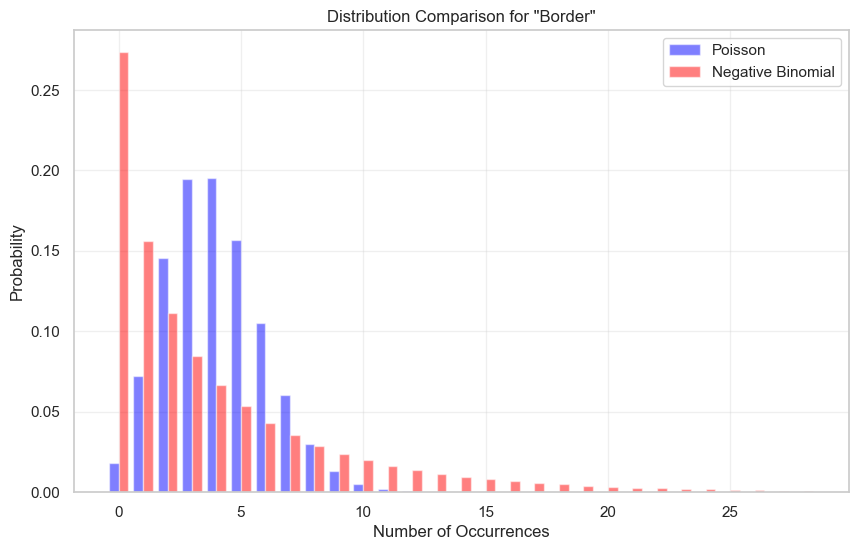

In [ ]:

def calculate_negative_binomial_predictions(df, avg_length):
    """Calculate predictions using Negative Binomial distribution"""
    predictions = []
    
    for phrase in SEARCH_PHRASES.keys():
        # Calculate rate per word and variance
        total_occurrences = df[phrase].sum()
        total_words = df['text_length'].sum()
        rate_per_word = total_occurrences / total_words
        
        # Expected occurrences in speech of avg_length
        expected = rate_per_word * avg_length
        
        # Calculate sample variance to estimate overdispersion
        counts_per_speech = df[phrase] / df['text_length'] * avg_length
        sample_variance = counts_per_speech.var()
        
        if sample_variance > expected and expected > 0:  # Check for overdispersion
            # Calculate r parameter for negative binomial using method of moments
            r = max(0.1, expected**2 / (sample_variance - expected))
            p = r/(r + expected)
        else:
            # If no overdispersion, fallback to quasi-Poisson
            r = 100
            p = r/(r + expected)
        
        # Calculate likelihoods using Negative Binomial CDF
        def nb_ge_k(r, p, k):
            return 1 - stats.nbinom.cdf(k-1, r, p)
        
        predictions.append({
            'Phrase': phrase,
            'Expected': expected,
            'Dispersion (r)': r,
            'Sample Variance': sample_variance,
            'P(≥1)': nb_ge_k(r, p, 1)
        })
    
    return pd.DataFrame(predictions)


def format_prediction_table(df):
    """Format prediction table with percentages"""
    formatted = df.copy()
    formatted = formatted.round(3)
    
    # Format probability columns as percentages
    formatted['P(≥1)'] = formatted['P(≥1)'].map('{:.1%}'.format)
    
    # Round other numeric columns
    formatted['Expected'] = formatted['Expected'].round(2)
    if 'Dispersion (r)' in formatted.columns:
        formatted['Dispersion (r)'] = formatted['Dispersion (r)'].round(2)
        formatted['Sample Variance'] = formatted['Sample Variance'].round(2)
    
    return formatted.sort_values('Expected', ascending=False)

def compare_models(poisson_df, nb_df):
    """Compare Poisson and Negative Binomial predictions"""
    comparison = pd.DataFrame()
    comparison['Phrase'] = poisson_df['Phrase']
    comparison['Expected'] = poisson_df['Expected']
    
    # Convert percentage strings back to floats for calculations
    comparison['Poisson P(≥1)'] = poisson_df['P(≥1)'].astype(float)
    comparison['NB P(≥1)'] = nb_df['P(≥1)'].astype(float)
    comparison['Δ P(≥1)'] = (comparison['NB P(≥1)'] - comparison['Poisson P(≥1)']) * 100
    
    comparison['Dispersion (r)'] = nb_df['Dispersion (r)']
    comparison['Sample Variance'] = nb_df['Sample Variance']
    
    # Format probability columns as percentages
    comparison['Poisson P(≥1)'] = comparison['Poisson P(≥1)'].map('{:.1%}'.format)
    comparison['NB P(≥1)'] = comparison['NB P(≥1)'].map('{:.1%}'.format)
    
    return comparison.round(3).sort_values('Δ P(≥1)', ascending=True)

def plot_distribution_comparison(phrase, poisson_df, nb_df, max_k=10):
    """Plot comparison of Poisson and Negative Binomial distributions"""
    phrase_data = poisson_df[poisson_df['Phrase'] == phrase].iloc[0]
    nb_data = nb_df[nb_df['Phrase'] == phrase].iloc[0]
    
    lambda_ = phrase_data['Expected']
    r = nb_data['Dispersion (r)']
    p = r/(r + lambda_)
    
    k = np.arange(0, max_k+1)
    poisson_pmf = stats.poisson.pmf(k, lambda_)
    nb_pmf = stats.nbinom.pmf(k, r, p)
    
    plt.figure(figsize=(10, 6))
    plt.bar(k-0.2, poisson_pmf, width=0.4, alpha=0.5, label='Poisson', color='blue')
    plt.bar(k+0.2, nb_pmf, width=0.4, alpha=0.5, label='Negative Binomial', color='red')
    plt.title(f'Distribution Comparison for "{phrase}"')
    plt.xlabel('Number of Occurrences')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Calculate predictions using both models
avg_speech_length = df_category['text_length'].mean()

print("Negative Binomial Predictions based on all appearances:")
nb_predictions = calculate_negative_binomial_predictions(df, avg_speech_length)
display(format_prediction_table(nb_predictions))

print("Negative Binomial Predictions based on category:")
nb_predictions = calculate_negative_binomial_predictions(df_category, avg_speech_length)
display(format_prediction_table(nb_predictions))


print("Negative Binomial Predictions based on all appearances post inauguration:")
nb_predictions_all = calculate_negative_binomial_predictions(df_post, avg_speech_length)
display(format_prediction_table(nb_predictions_all))

poisson_predictions = calculate_poisson_predictions(df_category_post, avg_speech_length)

print("\nModel Comparison (Negative Binomial vs Poisson):")
display(compare_models(poisson_predictions, nb_predictions))

# Plot distributions for most overdispersed phrases
most_overdispersed = nb_predictions[nb_predictions['Phrase'].isin(['Border', 'America', 'God', 'January 6', 'MAGA', 'LA', 'Rigged', 'Hell'])]
for _, row in most_overdispersed.iterrows():
    # Get parameters for both distributions
    phrase_data = poisson_predictions[poisson_predictions['Phrase'] == row['Phrase']].iloc[0]
    lambda_ = phrase_data['Expected']
    r = row['Dispersion (r)']
    p = r/(r + lambda_)
    
    # Find where probability becomes negligible (< 0.1%)
    k = 0
    while stats.nbinom.pmf(k, r, p) > 0.001 or stats.poisson.pmf(k, lambda_) > 0.001:
        k += 1
    
    # Ensure minimum k of 30 for 'America' to show full distribution
    if row['Phrase'] == 'America':
        k = max(k, 60)
    
    print(f"\nDistribution comparison for {row['Phrase']} (r = {row['Dispersion (r)']:.2f}):")
    plot_distribution_comparison(row['Phrase'], poisson_predictions, nb_predictions, max_k=k)

## Recent Usage in context

In [ ]:
def get_recent_contexts(df, phrase, n=5):
    """Get the n most recent contexts for a phrase"""
    # Create a list to store matches with their dates
    all_matches = []
    
    # Look through speeches from newest to oldest
    for _, row in df.sort_values('date', ascending=False).iterrows():
        matches = find_phrase_context(row['text'], SEARCH_PHRASES[phrase])
        for match in matches:
            all_matches.append({
                'date': row['date'],
                'category': row['category'],
                'context': match
            })
        if len(all_matches) >= n:
            break
    
    return pd.DataFrame(all_matches[:n])

# Get recent contexts for each phrase
for phrase in SEARCH_PHRASES.keys():
    contexts = get_recent_contexts(df_speech, phrase)
    if not contexts.empty:
        print(f"\n=== Recent usage of '{phrase}' ===\n")
        for _, row in contexts.iterrows():
            print(f"Date: {row['date'].strftime('%Y-%m-%d')} ({row['category']})")
            print(f"Context: {row['context']}\n")


=== Recent usage of 'EU' ===

Date: 2025-04-08 (speech)
Context: ... Climate Accord, what a beautiful name.

It's it beautiful? It was a rip off of the United States. Well, don't forget, you know, I mean, I'm negotiating with these people, but if you really look, the European Union, why was that set up? It was set up to screw the United States of America. It was -- they formed -- a group of countries got together and let's make life miserable for the United States of America on...

Date: 2025-04-08 (speech)
Context: ...ether and let's make life miserable for the United States of America on trade and other things.

And they have done that. They've done that. They've treated us very badly. We don't sell cars into the European Union. We don't sell -- they won't take our agriculture. They want their own. But we take their agriculture. We take their cars by the millions. I terminated the green new scam, one of the great scams, one...

Date: 2025-04-02 (speech)
Context: ...charges 75 percen

## Per-Speech Frequencies


/var/folders/_t/ds12gpdx0qb6km94c759_z9m0000gn/T/ipykernel_5752/1107231187.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


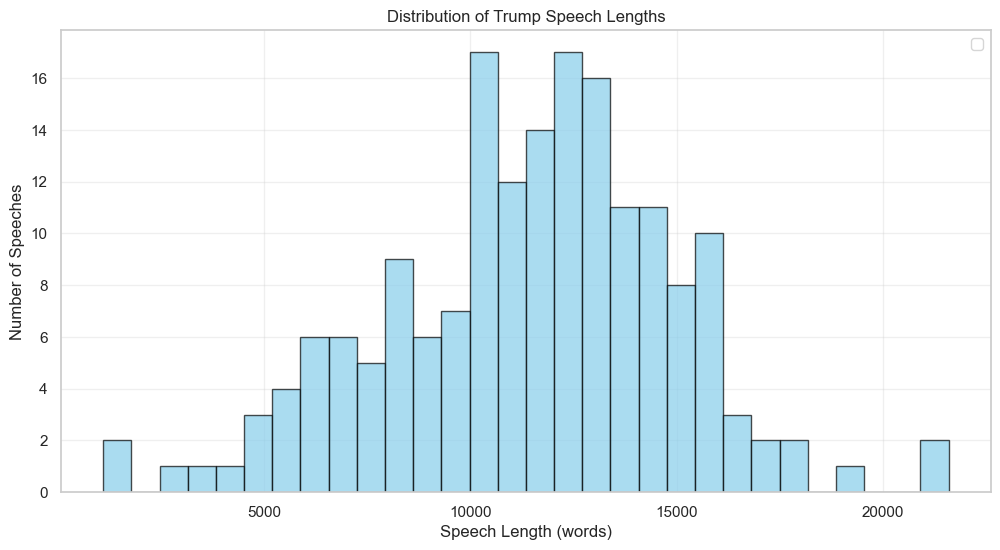

In [ ]:

# Plot distribution of speech lengths with SOTU average marked
plt.figure(figsize=(12, 6))
plt.hist(df_speech['text_length'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Speech Length (words)')
plt.ylabel('Number of Speeches')
plt.title('Distribution of Trump Speech Lengths')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
# Find and display the 5 shortest speeches with their full text
shortest_speeches = df_speech.nsmallest(5, 'text_length')

print("5 Shortest Speeches:")
for _, speech in shortest_speeches.iterrows():
    print("=" * 80)
    print(f"File: {speech['file']}")
    print(f"Date: {speech['date'].strftime('%Y-%m-%d')}")
    print(f"Category: {speech['category']}")
    print(f"Length: {speech['text_length']:,} words")
    print("-" * 40)
    print(speech['text'])
    print()




5 Shortest Speeches:
File: 2024-07-13_donald_trump_holds_a_political_rally_in_butler_pennsylvania.txt
Date: 2024-07-13
Category: speech
Length: 1,093 words
----------------------------------------
This is a big crowd. This is a big, big, beautiful crowd. I wish the fake news back there would, uh, show it. I wish they'd spin their cameras and show it because nobody would believe it. You know, the other day, Biden was saying, "I get big crowds," meaning him, he gets big crowds.

He doesn't know what a big... And there were like 93 people there. 93, you know what that is? That's where the front row Joes sit right here, 93. We got more than 93 front row Joes. Hello, Butler. Hello to Pennsylvania. I'm thrilled to be back in this beautiful Commonwealth with thousands of proud, hard-working Patriots, and that's what you are.

And we got to bring our country back to health, because our country is going to hell, if you haven't noticed. Millions and millions of people are pouring in from prisons

ValueError: cannot convert float NaN to integer

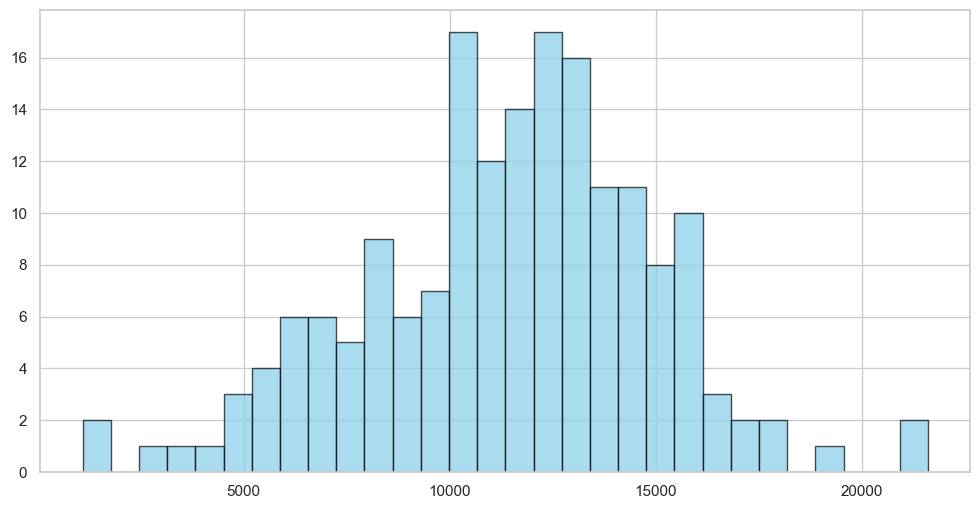

In [ ]:
sotu_mean_length = df_sotu['text_length'].mean()

# Plot distribution of speech lengths with SOTU average marked
plt.figure(figsize=(12, 6))
plt.hist(df_speech['text_length'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=sotu_mean_length, color='red', linestyle='--', label=f'Avg SOTU Length ({int(sotu_mean_length):,} words)')
plt.xlabel('Speech Length (words)')
plt.ylabel('Number of Speeches')
plt.title('Distribution of Trump Speech Lengths')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
# Calculate percentage of appearances containing each phrase at least once
phrase_percentages = {}
for phrase in SEARCH_PHRASES.keys():
    all_pct = (df[phrase] >= 1).mean() * 100
    speech_pct = (df_speech[phrase] >= 1).mean() * 100
    post_pct = (df_post[phrase] >= 1).mean() * 100
    phrase_percentages[phrase] = {
        'All Appearances': all_pct,
        'Speeches Only': speech_pct, 
        'Post-Inauguration': post_pct
    }

# Create DataFrame and sort by percentage in all appearances
phrase_df = pd.DataFrame.from_dict(phrase_percentages, orient='index')
phrase_df = phrase_df.sort_values('All Appearances', ascending=False)
phrase_df.index.name = 'Phrase'

# Format table for display
styled_df = phrase_df.style.format({
    'All Appearances': '{:.1f}%'.format,
    'Speeches Only': '{:.1f}%'.format,
    'Post-Inauguration': '{:.1f}%'.format
})

print("Percentage of Appearances Containing Each Phrase:")
display(styled_df)


Percentage of Appearances Containing Each Phrase:


In [ ]:
def create_frequency_comparison(df, df_speech, df_post):
    """Create a comparison table of per-speech frequencies across datasets"""
    results = []
    
    for phrase in SEARCH_PHRASES.keys():
        result = {
            'Phrase': phrase,
            'All Data P(≥1)': (df[phrase] >= 1).mean(),
            'All Speeches P(≥1)': (df_speech[phrase] >= 1).mean(),
            'Post-Inauguration P(≥1)': (df_post[phrase] >= 1).mean(),
            'All Data n': len(df),
            'All Speeches n': len(df_speech),
            'Post-Inauguration n': len(df_post)
        }
        results.append(result)
    
    comparison_df = pd.DataFrame(results)
    
    # Format percentages
    for col in ['All Data P(≥1)', 'All Speeches P(≥1)', 'Post-Inauguration P(≥1)']:
        comparison_df[col] = comparison_df[col].map('{:.1%}'.format)
    
    # Sort by All Data frequency
    comparison_df = comparison_df.sort_values('All Data P(≥1)', ascending=False)
    
    return comparison_df

print("Comparison of Per-Speech Frequencies (P(≥1)):")
comparison_table = create_frequency_comparison(df, df_speech, df_post)
display(comparison_table)

# ... existing code ...

Comparison of Per-Speech Frequencies (P(≥1)):


Phrase All Data P(≥1) All Speeches P(≥1)  \
44          Sleepy Joe           9.2%              26.0%   
18              Genius           8.7%              18.1%   
21               Biden          72.4%              97.2%   
7         Jobs Numbers           7.0%              18.6%   
24            Election          67.3%             100.0%   
26              Border          60.6%              98.3%   
47                 MIT           6.5%              18.6%   
1                  Fed           6.3%               6.8%   
9             Too Late           6.0%              11.3%   
15               China          59.9%              95.5%   
39              Russia          57.9%              89.8%   
33             Ukraine          54.0%              87.6%   
8            Inflation          53.1%              93.2%   
12              Energy          47.5%              90.4%   
4              Economy          47.5%              89.8%   
23              Israel          43.5%              74.0%   
27             Autopen           4.5%               1.7%   
45               MSDNC           4.5%               8.5%   
48               Tesla           4.3%               7.3%   
19             Bitcoin           4.2%               7.3%   
30                 Oil          39.5%              74.6%   
10               Peace          36.1%              66.1%   
5              Nuclear          35.4%              61.6%   
31         Transgender          29.4%              74.0%   
29              Canada          26.5%              33.3%   
3                Steel          25.5%              47.5%   
32                Elon          24.9%              42.4%   
17         Immigration          23.8%              53.1%   
46              Kamala          22.6%              54.8%   
40       Supreme Court          22.6%              43.5%   
37            Ballroom           2.7%               3.4%   
20  Big Beautiful Bill           2.5%               1.1%   
35                 DEI           2.2%               2.3%   
43              Golden          17.7%              37.9%   
13                Boom          17.1%              43.5%   
28               Japan          17.0%              35.6%   
36            Sanction          16.8%              27.1%   
22                Woke          16.6%              43.5%   
16               India          16.2%              22.6%   
2           Reciprocal          16.1%              28.2%   
14                  AI          13.9%              16.4%   
0                   EU          12.5%              10.2%   
11                Chip          10.6%               7.3%   
38            Earnings           1.6%               4.0%   
41              Nvidia           1.6%               2.3%   
6               Powell           1.3%               0.6%   
50              Cramer           0.4%               0.6%   
34             Epstein           0.4%               0.0%   
25                 BLS           0.2%               0.6%   
42             Adriana           0.0%               0.0%   
49      Sydney Sweeney           0.0%               0.0%   

   Post-Inauguration P(≥1)  All Data n  All Speeches n  Post-Inauguration n  
44                    2.9%         554             177                  278  
18                    6.1%         554             177                  278  
21                   61.9%         554             177                  278  
7                     0.0%         554             177                  278  
24                   48.6%         554             177                  278  
26                   48.2%         554             177                  278  
47                    1.4%         554             177                  278  
1                     6.5%         554             177                  278  
9                     5.0%         554             177                  278  
15                   52.5%         554             177                  278  
39                   50.7%         55

## Individual Phrase Analysis

In [ ]:
# Find speeches shorter than 6000 words with 4+ mentions of MAGA
short_maga_speeches = df[
    (df['text_length'] < 10200) & 
    (df['MAGA'] >= 4)
][['file', 'MAGA']]

print(f"\nSpeeches under 10200 words with 4+ mentions of MAGA:")
print(short_maga_speeches.sort_values('MAGA', ascending=False))

KeyError: 'MAGA'

In [ ]:
df[df['January 6'] > 0][['file', 'text_length', 'January 6', 'category']]

KeyError: 'January 6'

In [ ]:
df[df['LA'] > 0][['file', 'text_length', 'LA', 'category']].sort_values('file')

file  \
203               2023-09-29_donald_trump_addresses_a_california_gop_lunch_event_in_anaheim.txt   
233                          2023-10-01_donald_trump_holds_a_campaign_event_in_ottumwa_iowa.txt   
96                          2023-10-07_donald_trump_holds_a_campaign_rally_in_waterloo_iowa.txt   
136       2023-10-11_donald_trump_addresses_his_club_47_fan_club_in_west_palm_beach_florida.txt   
190                          2023-12-17_donald_trump_holds_a_political_rally_in_reno_nevada.txt   
114                     2024-01-05_donald_trump_holds_a_campaign_rally_in_sioux_center_iowa.txt   
146                          2024-01-06_donald_trump_holds_a_campaign_event_in_clinton_iowa.txt   
97                 2024-01-19_donald_trump_holds_a_political_rally_in_concord_new_hampshire.txt   
232              2024-01-21_donald_trump_holds_a_political_rally_in_rochester_new_hampshire.txt   
94                 2024-01-22_donald_trump_holds_a_political_rally_in_laconia_new_hampshire.txt   
201       2024-02-24_donald_trump_delivers_a_speech_at_the_2024_cpac_convention_in_maryland.txt   
85                     2024-03-02_donald_trump_holds_a_political_rally_in_richmond_virginia.txt   
324                   2024-05-02_donald_trump_speaks_to_reporters_before_court_in_manhattan.txt   
120             2024-06-09_donald_trump_holds_a_political_rally_at_sunset_park_in_las_vegas.txt   
132                     2024-06-18_donald_trump_holds_a_political_rally_in_racine_wisconsin.txt   
107         2024-06-22_donald_trump_addresses_the_faith_and_freedom_coalition_in_washington.txt   
90     2024-06-22_donald_trump_holds_a_political_rally_at_temple_university_in_philadelphia.txt   
128                        2024-07-09_donald_trump_holds_a_political_rally_in_doral_florida.txt   
230      2024-07-18_donald_trump_accepts_the_2024_gop_nomination_for_president_in_milwaukee.txt   
193  2024-07-20_donald_trump_holds_a_political_rally_with_jd_vance_in_grand_rapids_michigan.txt   
145             2024-07-24_donald_trump_holds_a_political_rally_in_charlotte_north_carolina.txt   
117              2024-07-31_donald_trump_holds_a_political_rally_in_harrisburg_pennsylvania.txt   
91                 2024-08-03_donald_trump_holds_a_political_rally_with_jd_vance_in_atlanta.txt   
59                                2024-08-08_donald_trump_speaks_to_reporters_at_mar-a-lago.txt   
111     2024-08-15_donald_trump_discusses_antisemitism_at_an_event_in_bedminster_new_jersey.txt   
63                     2024-08-15_donald_trump_speaks_to_reporters_in_bedminster_new_jersey.txt   
143            2024-08-17_donald_trump_holds_a_political_rally_in_wilkes-barre_pennsylvania.txt   
80                 2024-08-22_donald_trump_holds_a_campaign_event_in_montezuma_pass_arizona.txt   
108                     2024-08-23_donald_trump_holds_a_political_rally_in_glendale_arizona.txt   
98                             2024-09-05_donald_trump_addresses_the_new_york_economic_club.txt   
113       2024-09-06_donald_trump_addresses_the_fraternal_order_of_police_in_north_carolina.txt   
62                        2024-09-13_donald_trump_hosts_a_press_conference_near_los_angeles.txt   
134                     2024-09-19_donald_trump_speaks_at_anti-semitism_event_in_washington.txt   
170              2024-09-25_donald_trump_holds_a_campaign_rally_in_mint_hill_north_carolina.txt   
210                    2024-10-01_donald_trump_holds_a_campaign_rally_in_waunakee_wisconsin.txt   
148                             2024-10-10_donald_trump_addresses_the_detroit_economic_club.txt   
219                       2024-10-11_donald_trump_holds_a_campaign_rally_in_aurora_colorado.txt   
81                            2024-10-11_donald_trump_holds_a_campaign_rally_in_reno_nevada.txt   
171                  2024-10-12_donald_trump_holds_a_campaign_rally_in_coachella_california.txt   
246         2024-10-20_donald_trump_holds_a_town-hall_style_rally_in_lancaster_pennsylvania.txt   
286    2024-10-20_donald_trump_s

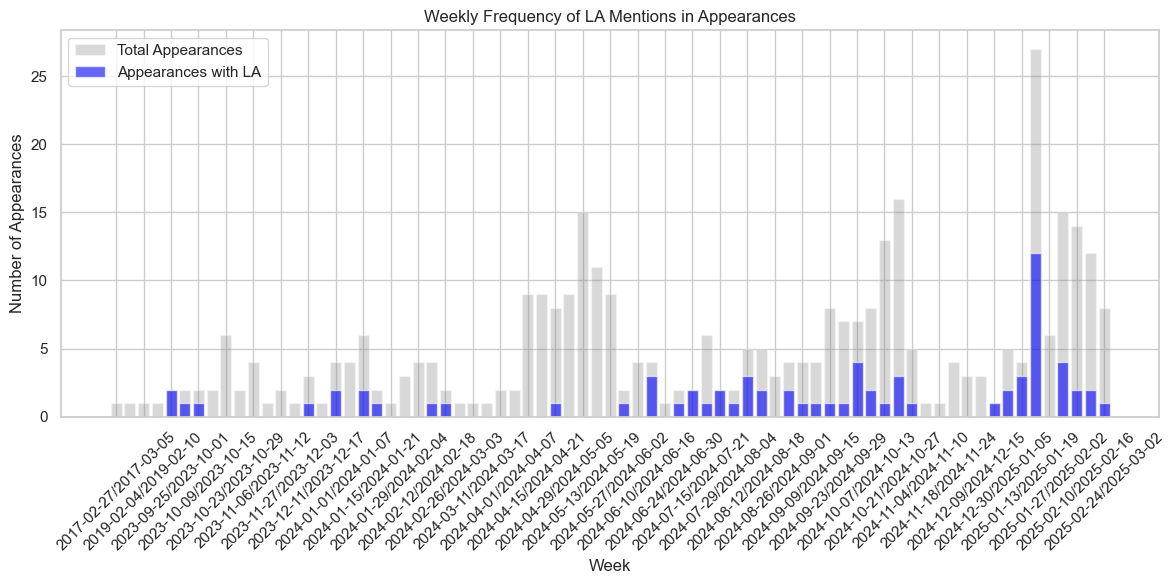

In [ ]:
# Convert date strings to datetime 
df['date'] = pd.to_datetime(df['date'])

# Create weekly bins
df['week'] = df['date'].dt.to_period('W')

# Group by week and calculate metrics
weekly_stats = df.groupby('week').agg({
    'file': 'count',  # Total speeches per week
    'LA': lambda x: (x > 0).sum()  # Speeches containing LA per week
}).reset_index()

# Create figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for speech counts
ax.bar(range(len(weekly_stats)), weekly_stats['file'], alpha=0.3, color='gray', label='Total Appearances')
ax.bar(range(len(weekly_stats)), weekly_stats['LA'], alpha=0.6, color='blue', label='Appearances with LA')

# Customize axes
ax.set_xlabel('Week')
ax.set_ylabel('Number of Appearances')

# Set x-axis ticks to show dates every 2 weeks
tick_indices = range(0, len(weekly_stats), 2)
plt.xticks(tick_indices, [str(weekly_stats['week'].iloc[i]) for i in tick_indices], rotation=45)

# Add legend
ax.legend(loc='upper left')

plt.title('Weekly Frequency of LA Mentions in Appearances')
plt.tight_layout()
plt.show()
